# Here we're going to take Final Fantasy MIDIs and convert them to 2D images with multiple channels
- the x information will be the offset of the note
- the y information will be the pitch of the note
- the channels will stack multiple 'measures' consecutively, so you have longer time domain info considered
- since we'll be training a GAN we don't need validation info


# In this notebook instead of arranging pitches by A,A#,B,C,C#,D,D#,E,F,F#,G,G#, we'll arrange them by the circle of fifths
# This gives us the advantage that related pixels in physical space are musically related as well
# We'll extract all songs with a major key, and arrange pitches by A,E,B,Gb,Db,Ab,Eb,Bb,F,C,G,D

# So actually there are more Final Fantasy songs in a minor key, so let's use that.
# Minor key circle of fifths is A,E,B,F#,C#,G#,D#,Bb,F,C,G,D

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
import pickle
from keras.utils import np_utils
from tensorflow.keras.layers import InputLayer, Dense, LSTM, Dropout, Activation
from tensorflow.keras.models import Sequential
import math

from music21 import converter, instrument, note, chord, stream, key
import glob
import music21

from keras.utils import np_utils
import os

FONTSIZE=24
plt.rcParams['figure.figsize']=(15,8)
plt.rcParams['font.size']=FONTSIZE

# Visualize the MIDI information

In [3]:
filenames=glob.glob('../Final_Fantasy/FinalFantasy*.mid')
for i in filenames:
    midi=converter.parse(i)
    print(midi.keySignature)

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


IndexError: list index out of range

First we need a way of predicting the key (since our midi files don't list a key for us)

In [4]:
filenames=glob.glob('../Final_Fantasy/FinalFantasy*.mid')
a=music21.analysis.discrete.KrumhanslSchmuckler() #this is an algorithm that attempts to predict the key of a midi file
num_songs_major=0
num_songs_minor=0
for i in range(len(filenames)):
    try:
        midi=converter.parse(filenames[i])
        print(a.getSolution(midi))
        
        if str(a.getSolution(midi))[-5:]=='major':
            num_songs_major+=1
        elif str(a.getSolution(midi))[-5:]=='minor':
            num_songs_minor+=1
        else:
            raise ValueError("A solution is not caught by major or minor")
    except:
        pass

G major
e minor
D major
C major
a minor
a minor
C major
B major
E major
a minor
f minor
E major
F major
G major
g minor
a minor
E major
C major
G major
b minor
G major
f minor
d minor
b minor
C major
e minor
d minor
a minor
D major
E major
D major
B- major
a minor
B major
A- major
C major
B- major
B- major
a minor
c minor
f minor
f minor
F major
d minor
d minor
f minor
d minor
C major
C major
a minor
a minor
A- major
E- major
c minor
c minor
g minor
G major
D major
C major
b minor
c minor
C# major
f# minor
d minor
F major
g minor
A major
a minor
E major
A major
A major
a minor
a minor
b minor
a minor
a minor
G major
e minor
c minor
c minor
F major
d minor
a minor
a minor
a minor
C major
d minor
a minor
D major
g minor
g# minor
D major
a minor
e minor
d minor
a minor
D major
c minor
B major
b- minor
F# major
a minor
c minor
D major
f# minor
B- major
E major
G major
F major
A- major
G major
f# minor
G major
D major
d minor
A- major
a minor
G major
G major
e minor
A major
a minor
C major


In [5]:
print("Number of Songs in a Major Key: "+str(num_songs_major))
print("Number of Songs in a Minor Key: "+str(num_songs_minor))

Number of Songs in a Major Key: 87
Number of Songs in a Minor Key: 104


# Ok now let's extract our notes for all songs with a predicted minor key

In [6]:
# Let's figure out our whole range of notes

filenames=glob.glob('../Final_Fantasy/FinalFantasy*.mid')

pitches=[]
offsets=[]
durations=[]

skip_song_idx=[]
count=-1
for i in filenames:
    count+=1
    try:
    
        filename=i
        midi=converter.parse(filename)
        if str(a.getSolution(midi))[-5:]=='major':
            skip_song_idx.append(count)
        elif str(a.getSolution(midi))[-5:]=='minor':
            s2=instrument.partitionByInstrument(midi)

            for part in s2.parts:
                if 'Piano' in str(part):
                    notes_to_parse=part.recurse()
                    for element in notes_to_parse:

                        if isinstance(element,note.Note):
                            offsets.append(element.offset)
                            pitches.append(element.nameWithOctave)
                            durations.append(element.duration.quarterLength)

                        elif isinstance(element,chord.Chord):

                            for pitch in element.pitches:
                                offsets.append(element.offset)
                                pitches.append(pitch.nameWithOctave)
                                durations.append(element.duration.quarterLength)
                                
    except:
        skip_song_idx.append(count)
        
idx_all=np.arange(len(filenames))
idx_keep=np.delete(idx_all,skip_song_idx)
                
print(max(offsets))
print(len(offsets))
print(len(pitches))
print(len(durations))

2607.0
86700
86700
86700


In [7]:
print(len(idx_keep))
print(len(skip_song_idx))

101
91


In [8]:
print(set(pitches))

{'D6', 'C5', 'C#5', 'B2', 'B-2', 'G1', 'G#2', 'A5', 'E5', 'D4', 'F5', 'C#2', 'F#3', 'B-5', 'D1', 'B-1', 'C#3', 'C4', 'F4', 'B-4', 'E1', 'A6', 'F3', 'A2', 'E-3', 'C2', 'F1', 'G4', 'G#4', 'F2', 'E6', 'E-1', 'E7', 'E-4', 'F#6', 'B-6', 'F#2', 'B-3', 'A1', 'E2', 'G6', 'G3', 'E-6', 'G#5', 'G5', 'A4', 'E-5', 'B1', 'G#3', 'F6', 'G#1', 'B6', 'C#7', 'E3', 'D2', 'F#5', 'C7', 'G#6', 'F#1', 'C6', 'B5', 'B4', 'D5', 'E4', 'C#4', 'F#4', 'C1', 'A3', 'E-2', 'D7', 'D3', 'B3', 'G2', 'C3', 'C#6'}


In [9]:
lengths=[len(i) for i in pitches]
print(set(lengths))

{2, 3}


In [10]:
print(set(durations))

{0.5, 1.0, 2.0, 3.0, 4.0, 0.25, 6.0, 0.75, 8.0, 1.5, 0.0, 2.5, 7.0, 10.0, 12.0, 9.0, 3.5, 3.75, 2.75, 2.25, 3.25, 4.5, 4.25, 4.75, 15.0, 5.0, 5.5, 5.75, 1.75, 6.75, 1.25, 6.5, 6.25, 7.75, 7.25, 7.5, Fraction(2, 3), Fraction(5, 3), Fraction(8, 3), Fraction(11, 3), 10.5, 11.25, 11.75, 11.0, 12.25, Fraction(1, 3), Fraction(4, 3), Fraction(7, 3), Fraction(10, 3), Fraction(22, 3)}


In [11]:
print(max(offsets))

2607.0


In [12]:
# make a dictionary that maps notes to ints

#this will have key=pitch value=integer

pitch_dict={}

min_octave=-6
num_octaves=14

notes=['A','E','B','F#','C#','G#','D#','A#','F','C','G','D']
num_notes=len(notes)

count=-1
for i in range(num_octaves):
    for j in range(num_notes):
        count+=1
        octave=min_octave+i
        note_tmp=notes[j]
        pitch=str(note_tmp)+str(octave)
        
        pitch_dict[pitch]=int(count)
        
num_pitches=count+1
print(num_pitches)

168


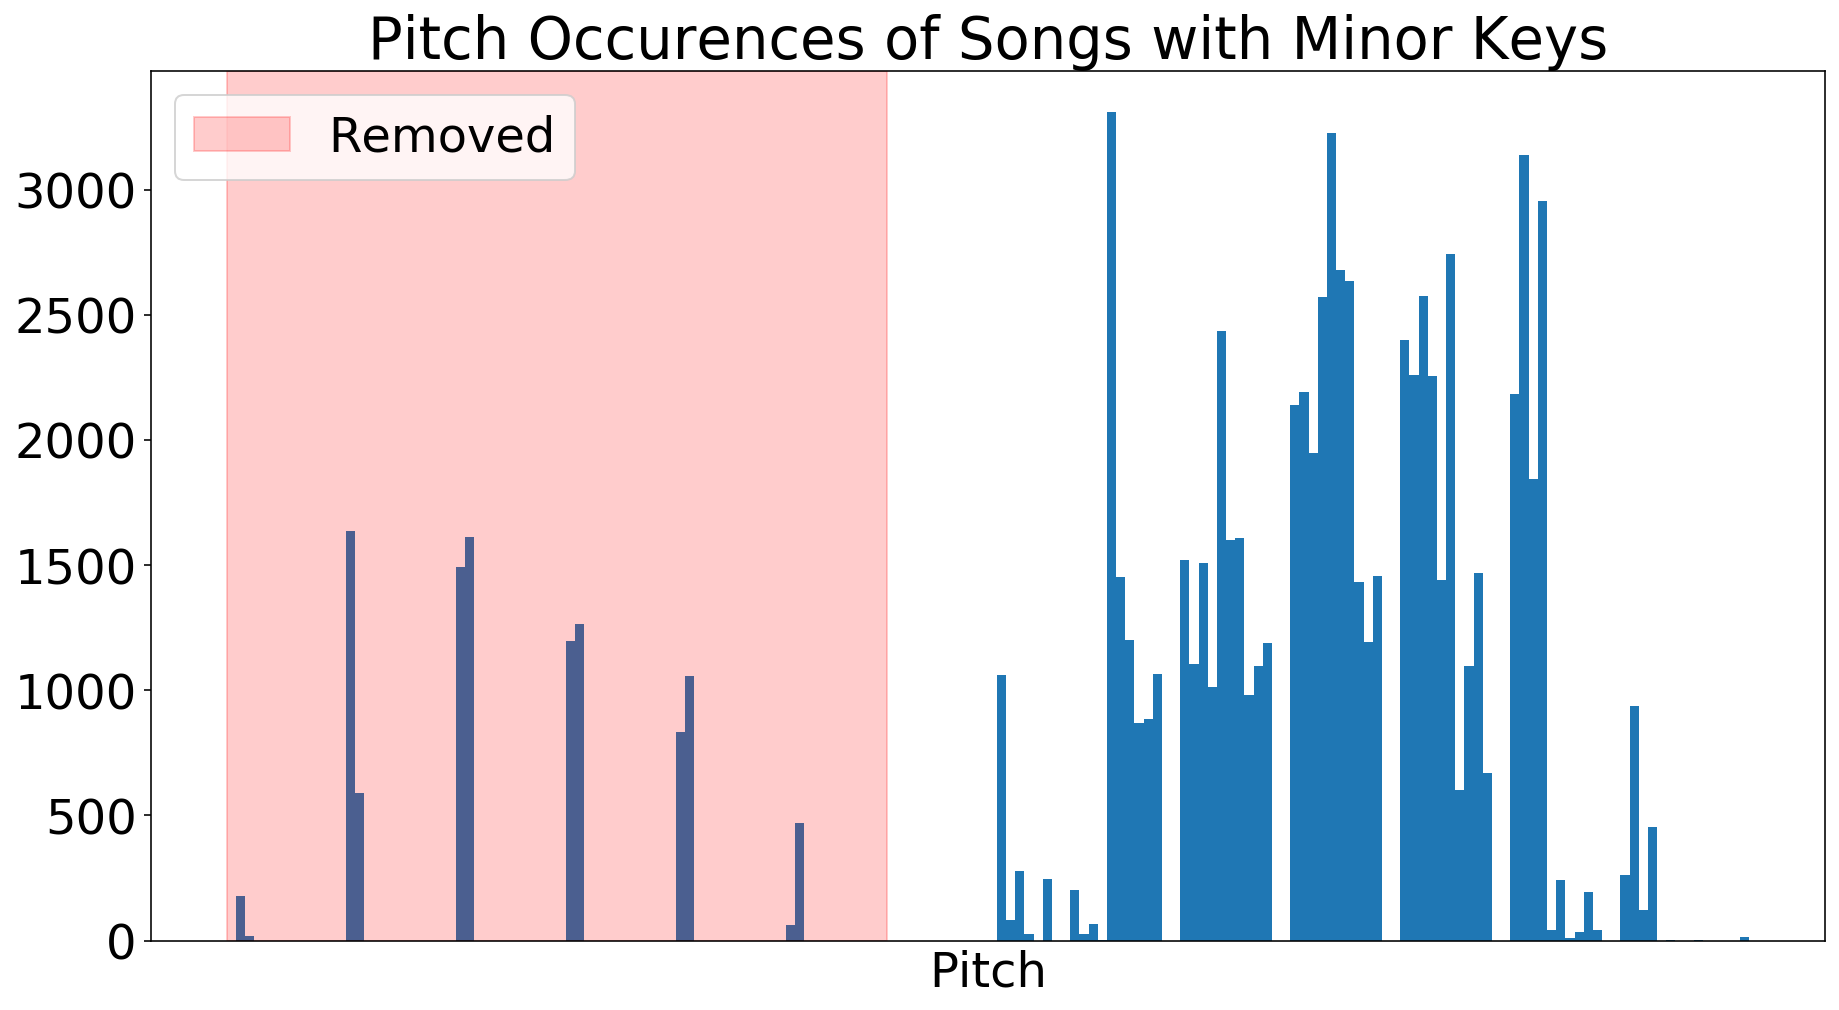

In [15]:
#let's see how often each note shows up
ints=[]

pitch_test='A0'
int_test=pitch_dict[pitch_test]

pitch_test2='A-6'
int_test_low=0

for i in pitches:    
    ints.append(pitch_dict[i])
    
bins=np.arange(0,max(ints))
ignored,ignored,ignored=plt.hist(ints,bins=bins)
plt.axvspan(int_test_low,int_test,color='r',alpha=0.2,label='Removed')
plt.title('Pitch Occurences of Songs with Minor Keys')
plt.xlabel('Pitch')
plt.legend(loc='upper left')
plt.xticks(ticks=[],labels=[])
plt.savefig('../Final_Talk/Pitch_hist.png',bbox_inches='tight')

    

# We could make our images significantly smaller by removing everything below A1

In [40]:
# make a dictionary that maps notes to ints

#this will have key=pitch value=integer

#I'm dropping our lowest octave down to 0 and moving up 8 so our images can be squares

pitch_dict={}

min_octave=0
num_octaves=8

notes=['A','E','B','F#','C#','G#','D#','A#','F','C','G','D']
num_notes=len(notes)

count=-1
for i in range(num_octaves):
    for j in range(num_notes):
        count+=1
        octave=min_octave+i
        note_tmp=notes[j]
        pitch=str(note_tmp)+str(octave)
        
        pitch_dict[pitch]=int(count)
        
num_pitches=count+1
print(num_pitches)

96


In [47]:
#fp=open("pitch_dict_convgan_final_fantasy_fifths.pkl",'wb')
#pickle.dump(pitch_dict,fp)
#fp.close()

In [41]:
def check_pitch(pitch):
    if len(pitch)==2:
        octave=int(pitch[-1])
    if len(pitch)==3:
        if '#' in pitch:
            octave=int(pitch[-1])
        if '-' in pitch:
            octave=int(pitch[1:])
        
    if octave>=0:
        return True
    else:
        return False

In [42]:
pixel_length=float(1/12) 
grid_out=[]

measures_per_image=2
image_width=int(4*measures_per_image/pixel_length)
image_height=int(num_pitches)
num_channels=int(4)
count=-1

for i in range(len(filenames)):
    filename=filenames[i]
    if i in idx_keep:
        #idx_keep already removes songs in a major key
        count+=1
        
        #populate pitches, durations, and offsets
        midi=converter.parse(filename)
        s2=instrument.partitionByInstrument(midi)
        pitches=[]
        offsets=[]
        durations=[]

        for part in s2.parts:
            print("song "+str(count)+" " +str(part))
            if 'Piano' in str(part):
                notes_to_parse=part.recurse()
                for element in notes_to_parse:

                    if isinstance(element,note.Note):
                        #only keep if pitch is in octave 1 or greater
                        if check_pitch(element.nameWithOctave):
                            offsets.append(element.offset)
                            pitches.append(element.nameWithOctave)
                            durations.append(element.duration.quarterLength)

                    elif isinstance(element,chord.Chord):

                        for pitch in element.pitches:
                            #only keep if pitch is in octave 1 or greater
                            if check_pitch(pitch.nameWithOctave):
                                offsets.append(element.offset)
                                pitches.append(pitch.nameWithOctave)
                                durations.append(element.duration.quarterLength)
        #print(pitches)

        if len(offsets)>0:
                                
            if max(offsets)>num_channels*measures_per_image*4:
                #the song is long enough

                #create grid
                grid_temp=np.zeros((num_pitches,int(max(offsets)/pixel_length)))

                for j in range(len(offsets)):


                    offset_temp=offsets[j]
                    pitch_temp=pitches[j]
                    duration_temp=durations[j]
                    



                    #find column grid value
                    column_start_idx=int(offset_temp/pixel_length)
                    delta=duration_temp/pixel_length
                    column_end_idx=int(column_start_idx+delta)

                    #find row grid value
                    row_idx=int(pitch_dict[pitch_temp])

                    grid_temp[row_idx,column_start_idx:column_end_idx]=1



                grid_out.append(grid_temp)
        

song 0 <music21.stream.Part Piano>
song 1 <music21.stream.Part Piano>
song 2 <music21.stream.Part Piano>
song 3 <music21.stream.Part Piccolo>
song 3 <music21.stream.Part Oboe>
song 3 <music21.stream.Part StringInstrument>
song 3 <music21.stream.Part object at 0x7f3989567210>
song 4 <music21.stream.Part Piano>
song 5 <music21.stream.Part Piano>
song 6 <music21.stream.Part Piano>
song 7 <music21.stream.Part Piano>
song 8 <music21.stream.Part Piano>
song 9 <music21.stream.Part Piano>
song 10 <music21.stream.Part Piano>
song 11 <music21.stream.Part Piano>
song 12 <music21.stream.Part Piano>
song 13 <music21.stream.Part Piano>
song 14 <music21.stream.Part Piano>
song 15 <music21.stream.Part Piano>
song 16 <music21.stream.Part Piano>
song 17 <music21.stream.Part Piano>
song 18 <music21.stream.Part Piano>
song 19 <music21.stream.Part Piano>
song 20 <music21.stream.Part Piano>
song 21 <music21.stream.Part Piano>
song 22 <music21.stream.Part Piano>
song 23 <music21.stream.Part Piano>
song 24 <m

In [43]:
print(image_width)
print(image_height)

96
96


In [44]:
print(len(grid_out))
print(len(idx_keep))

91
101


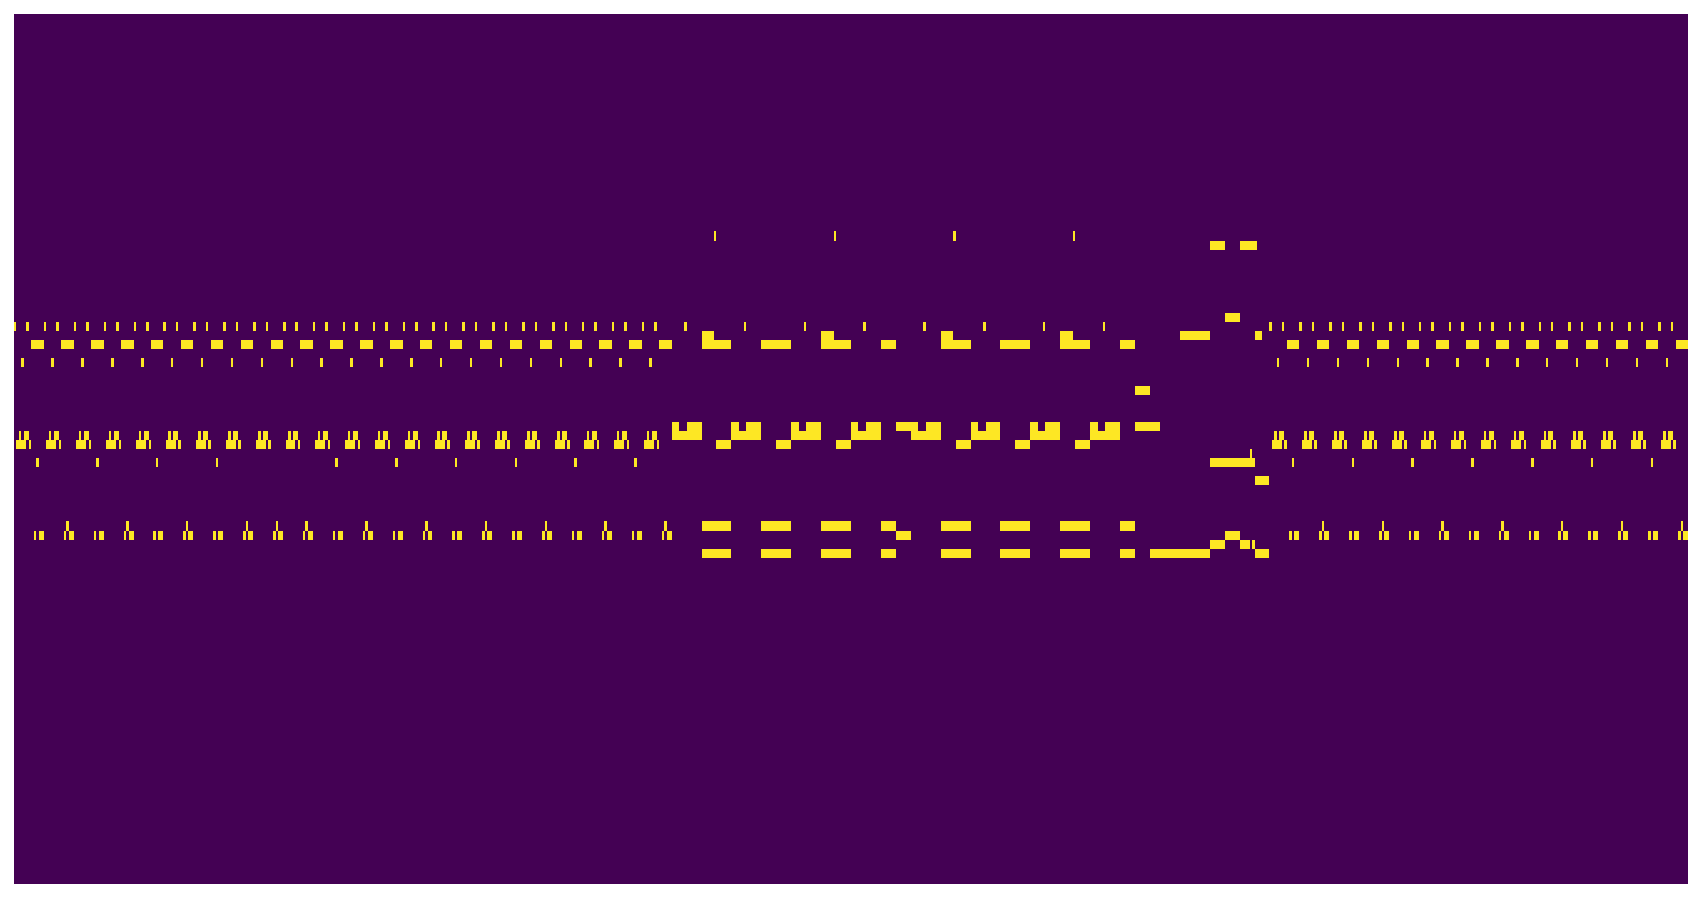

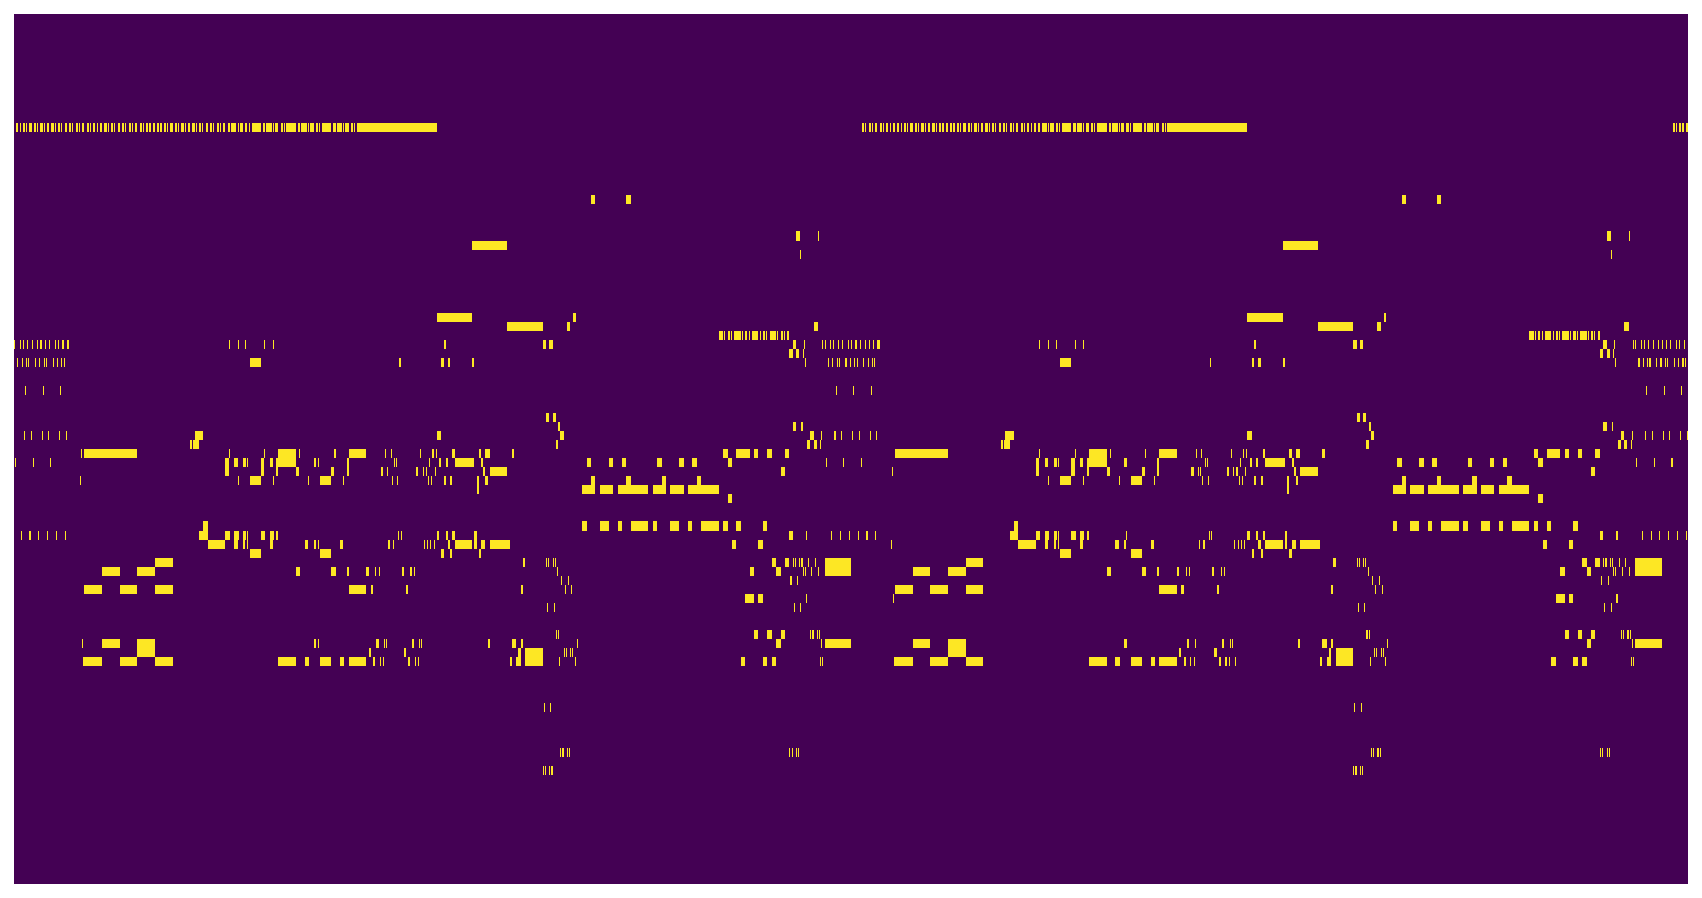

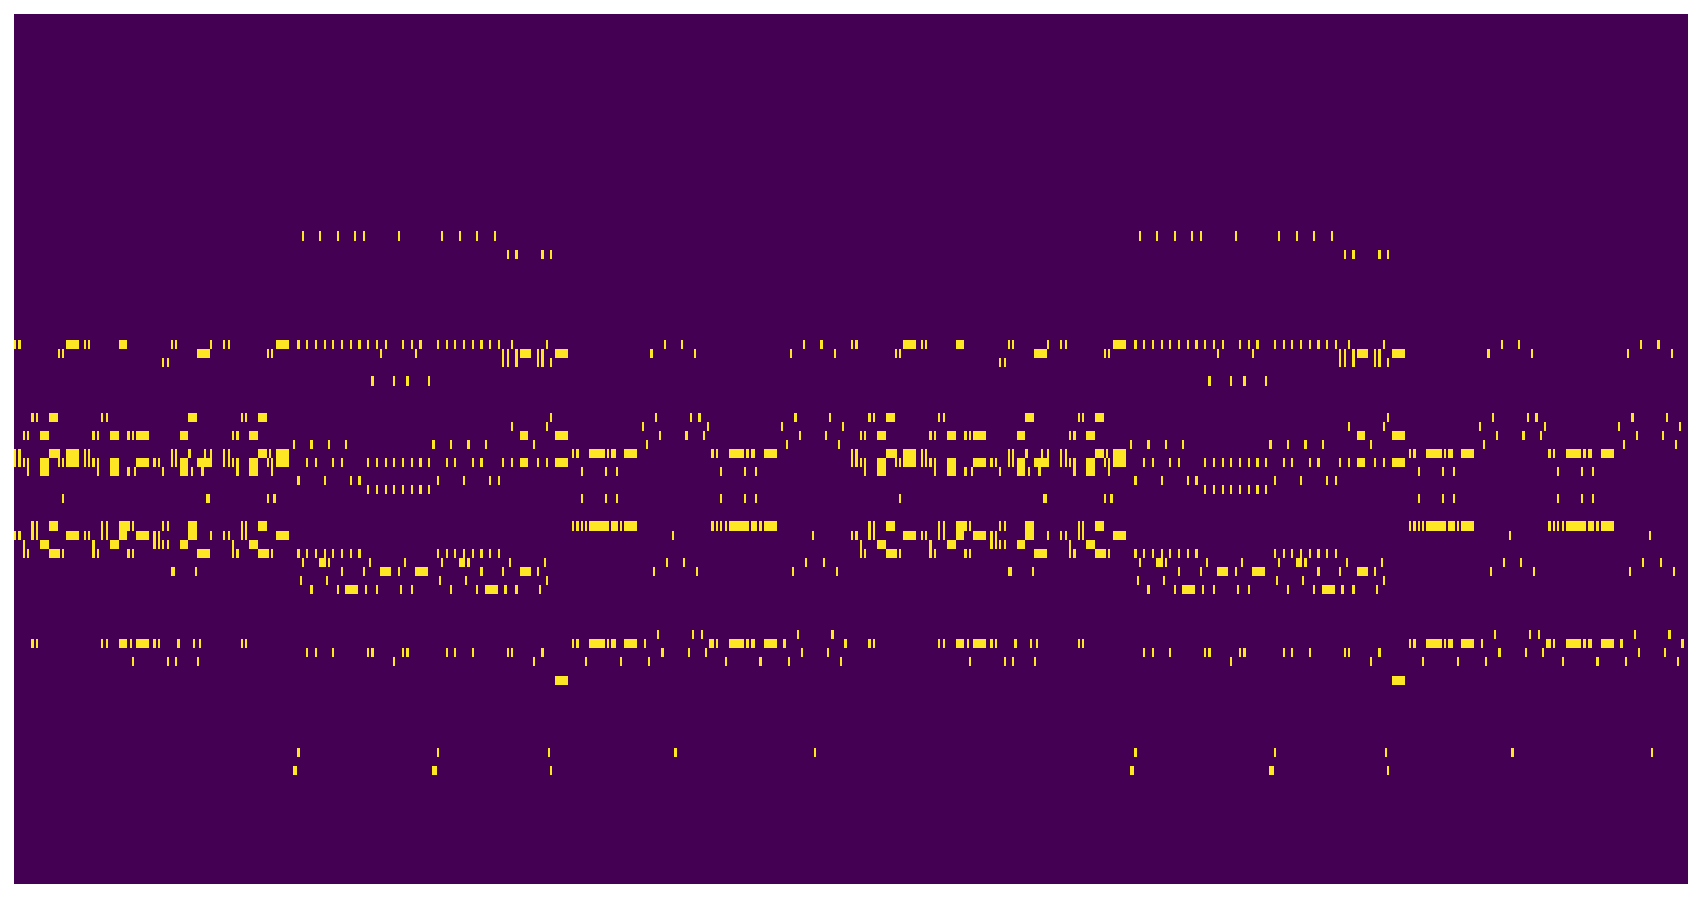

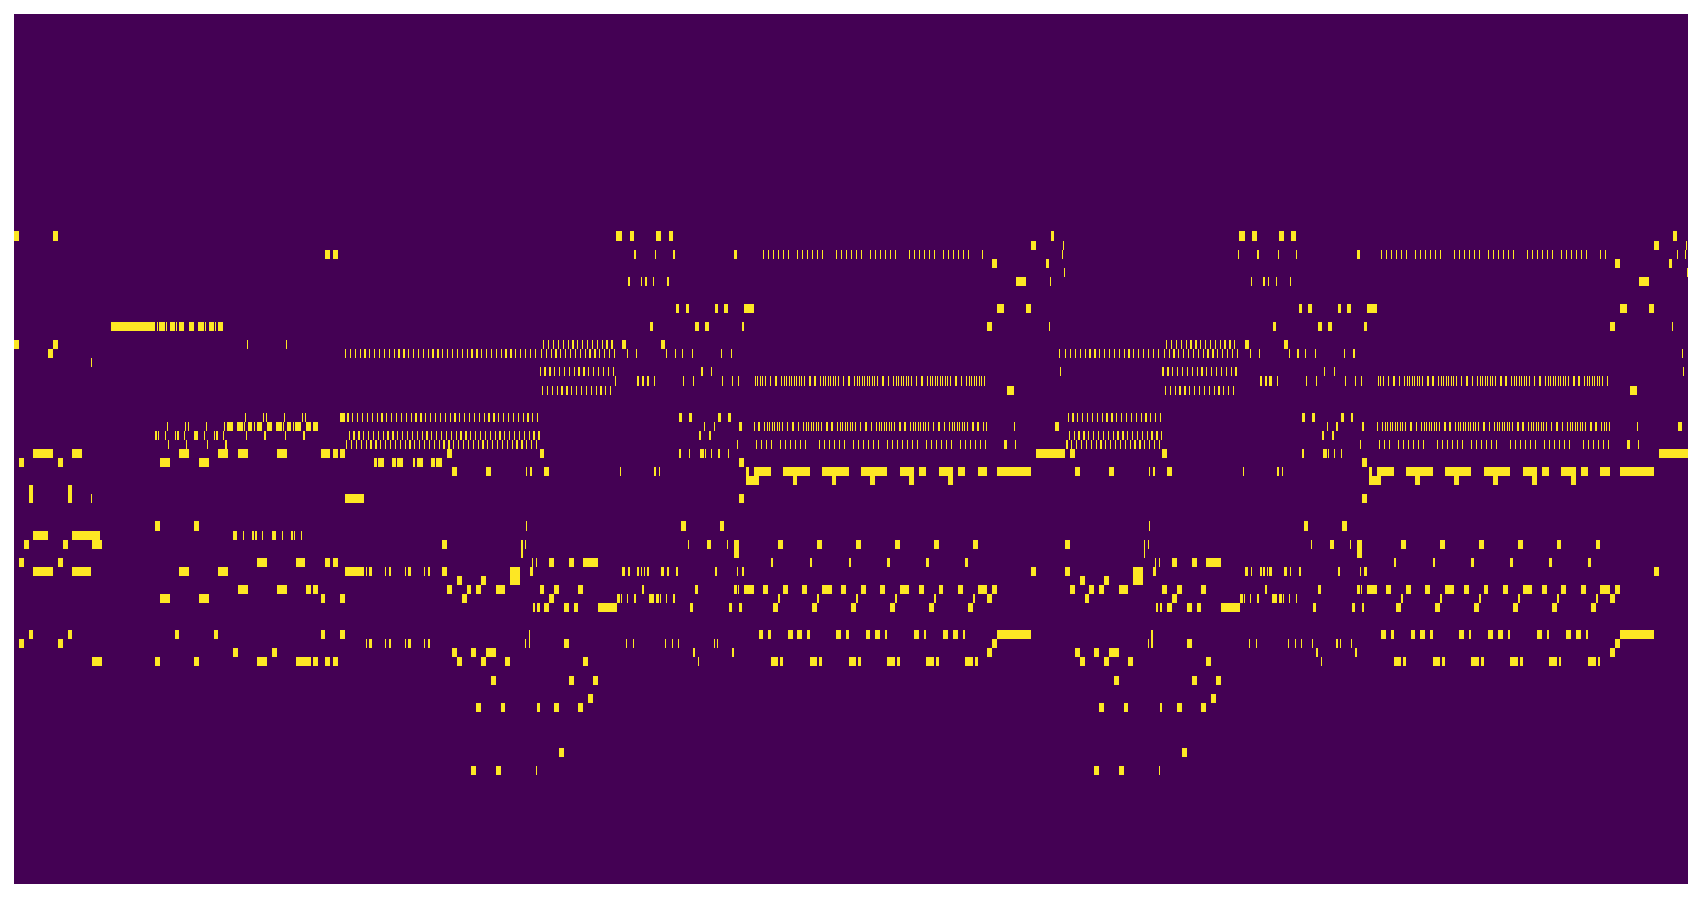

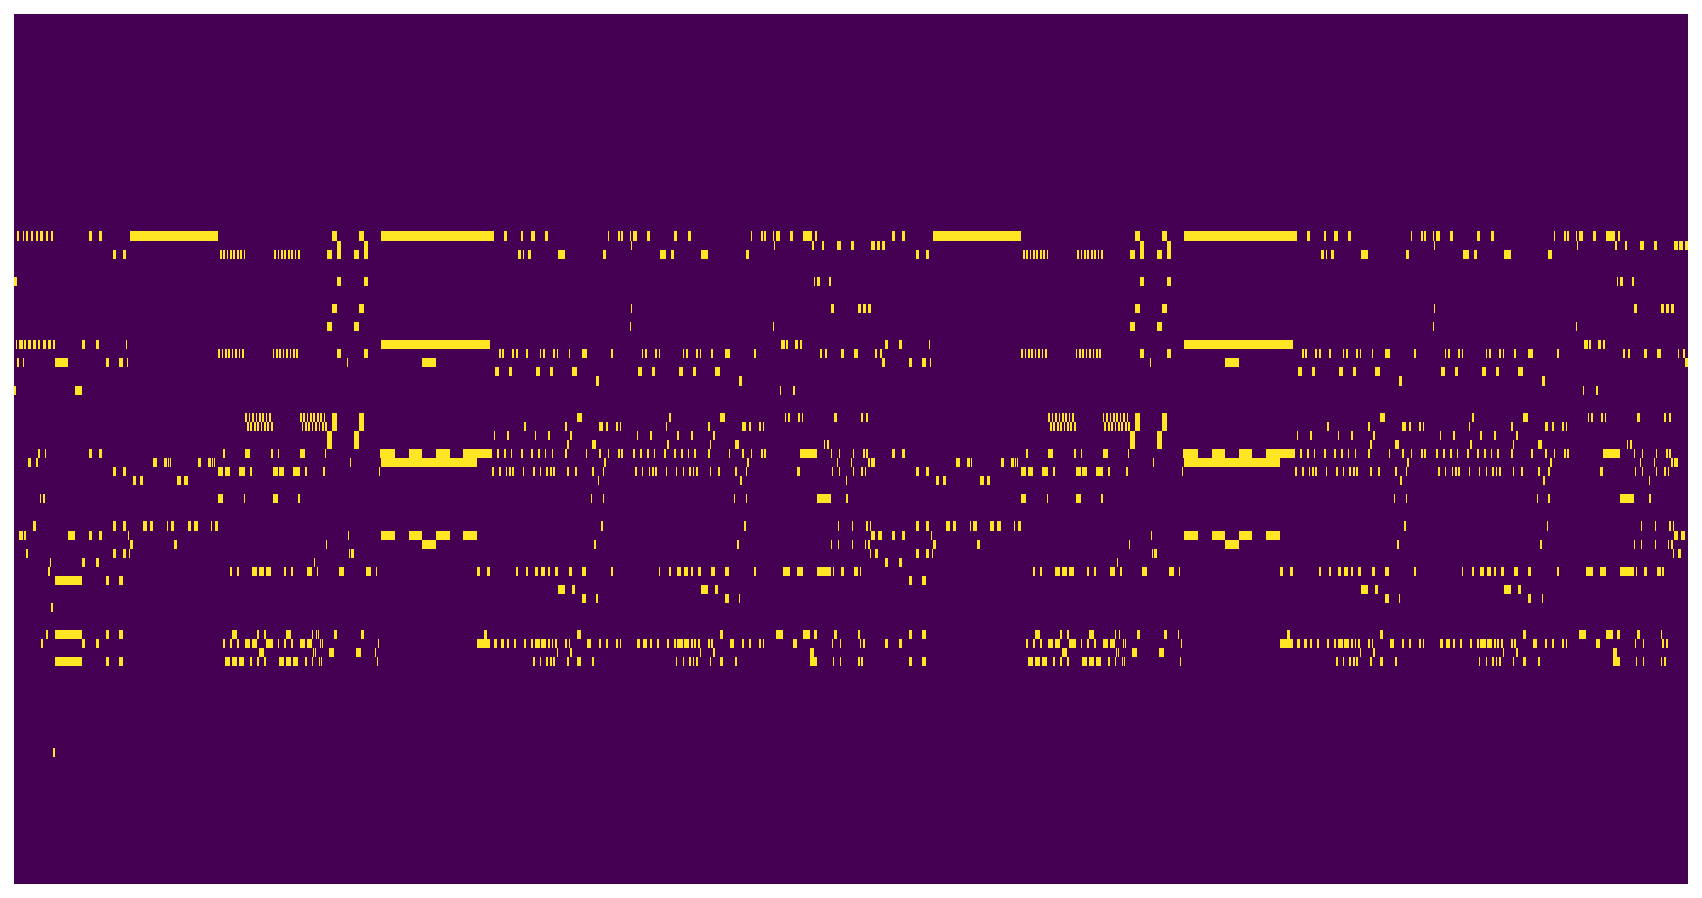

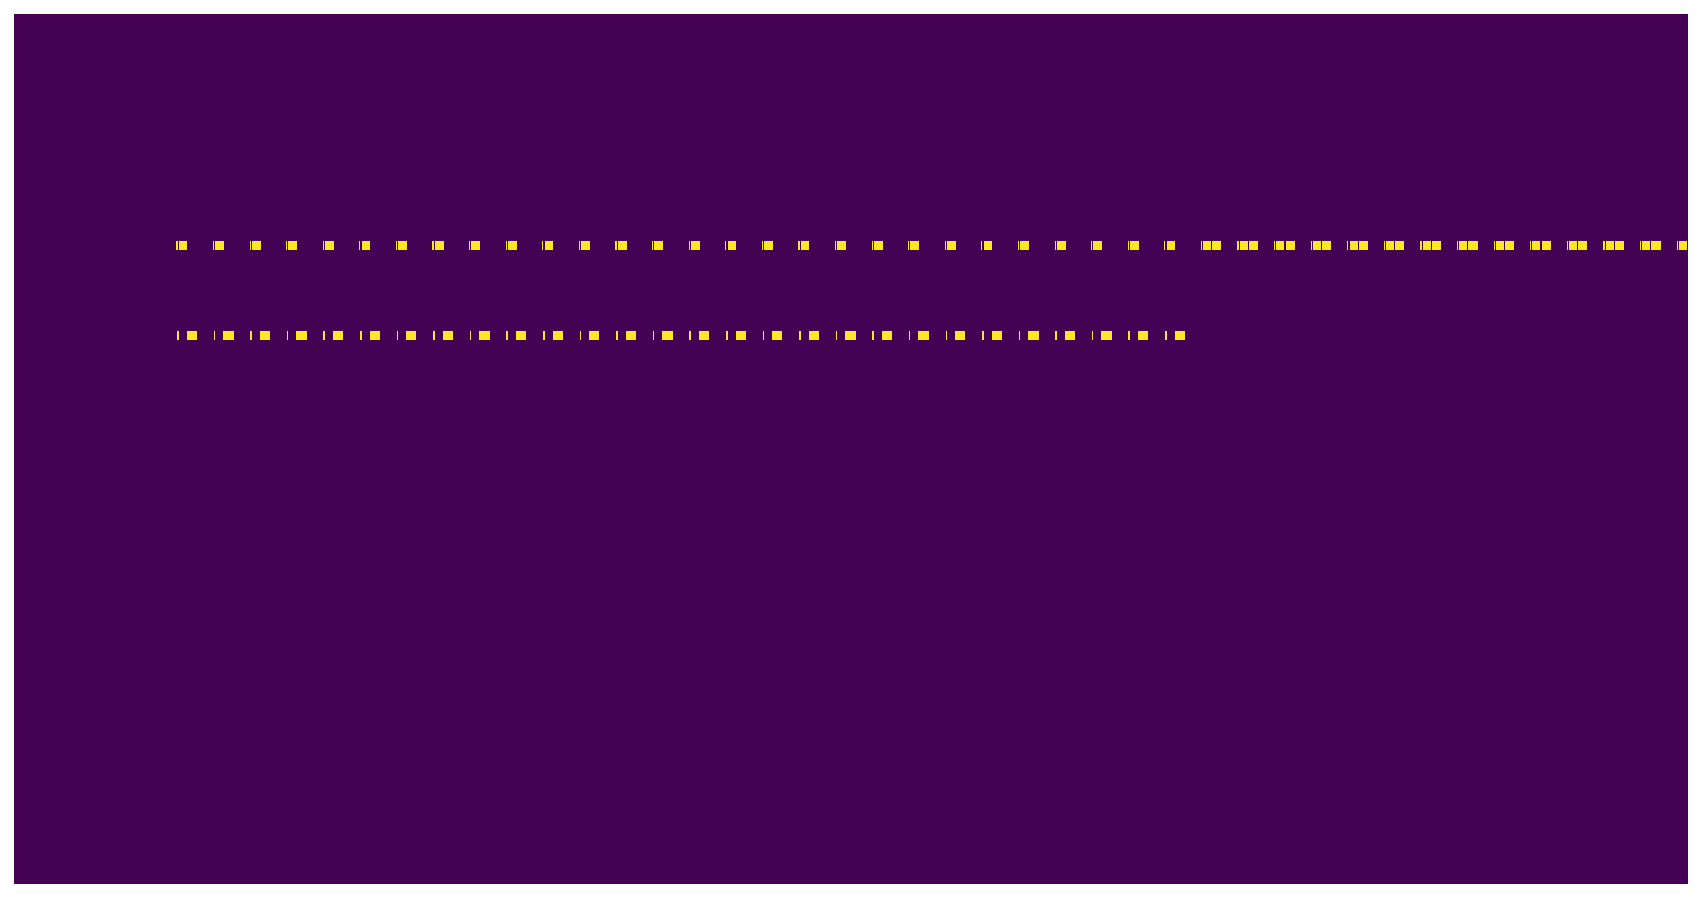

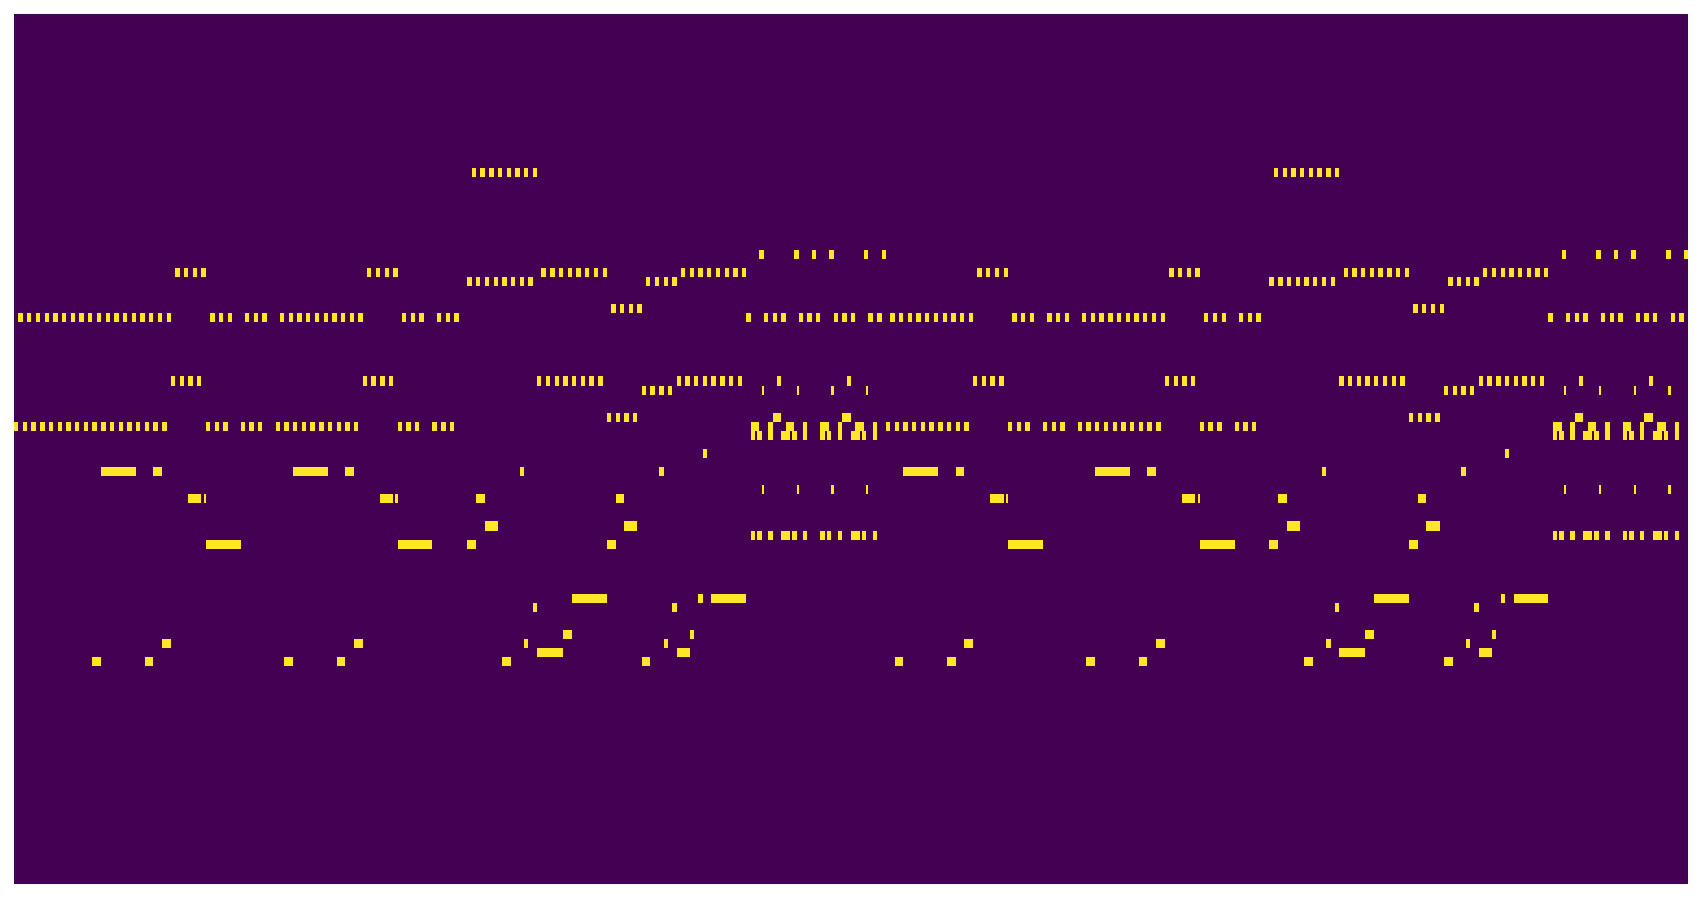

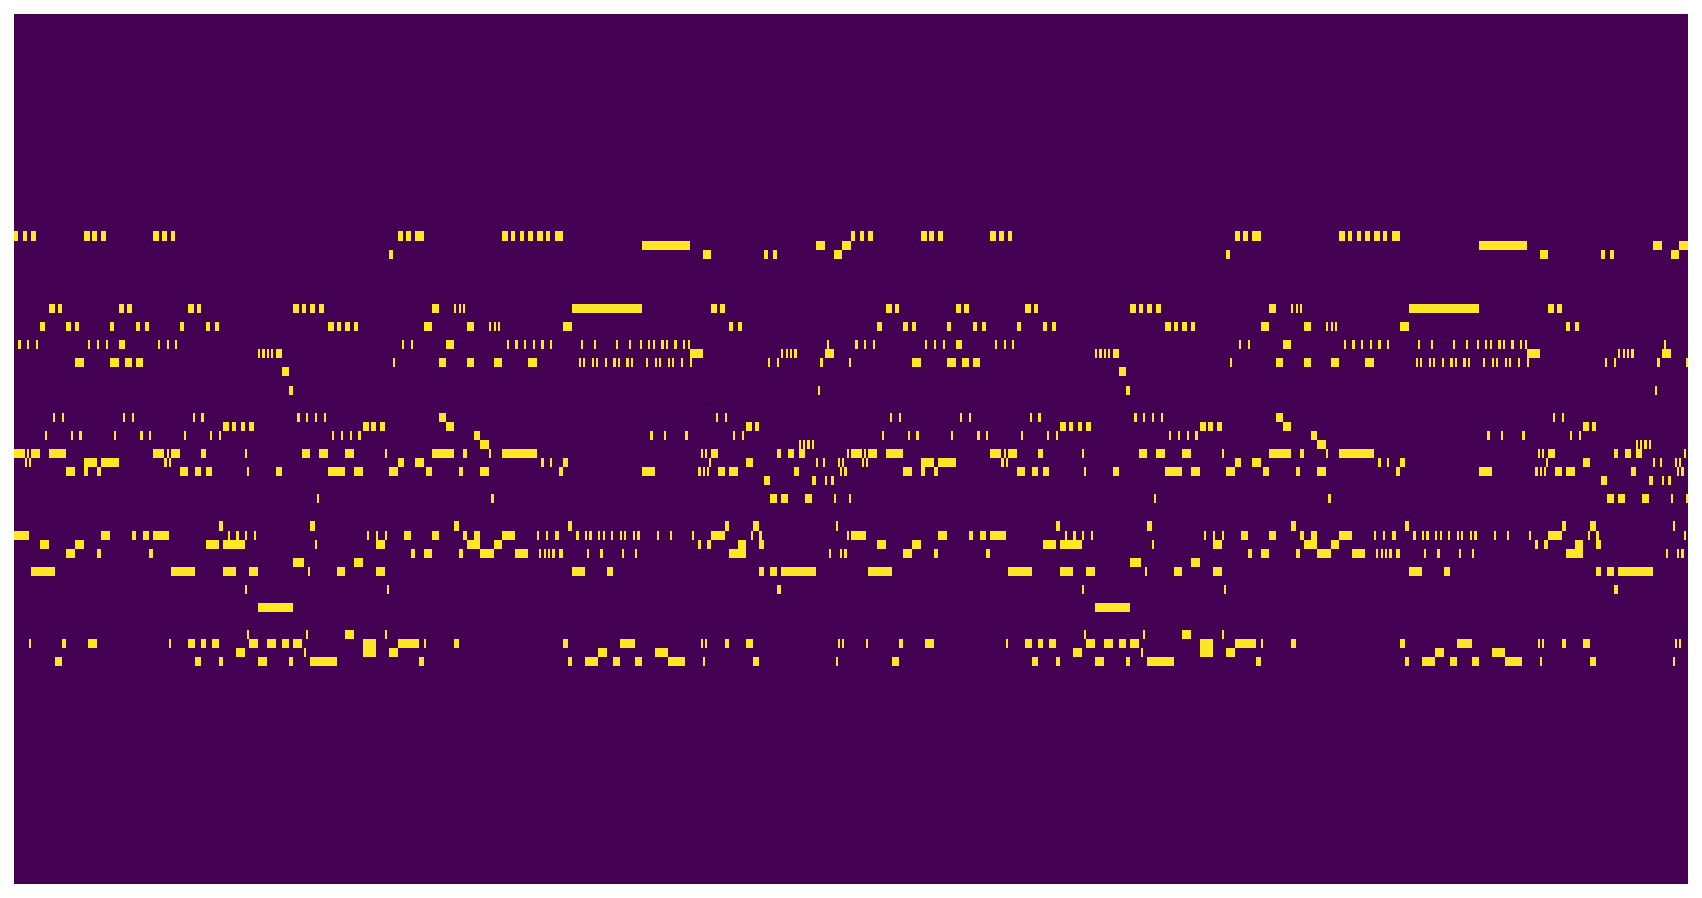

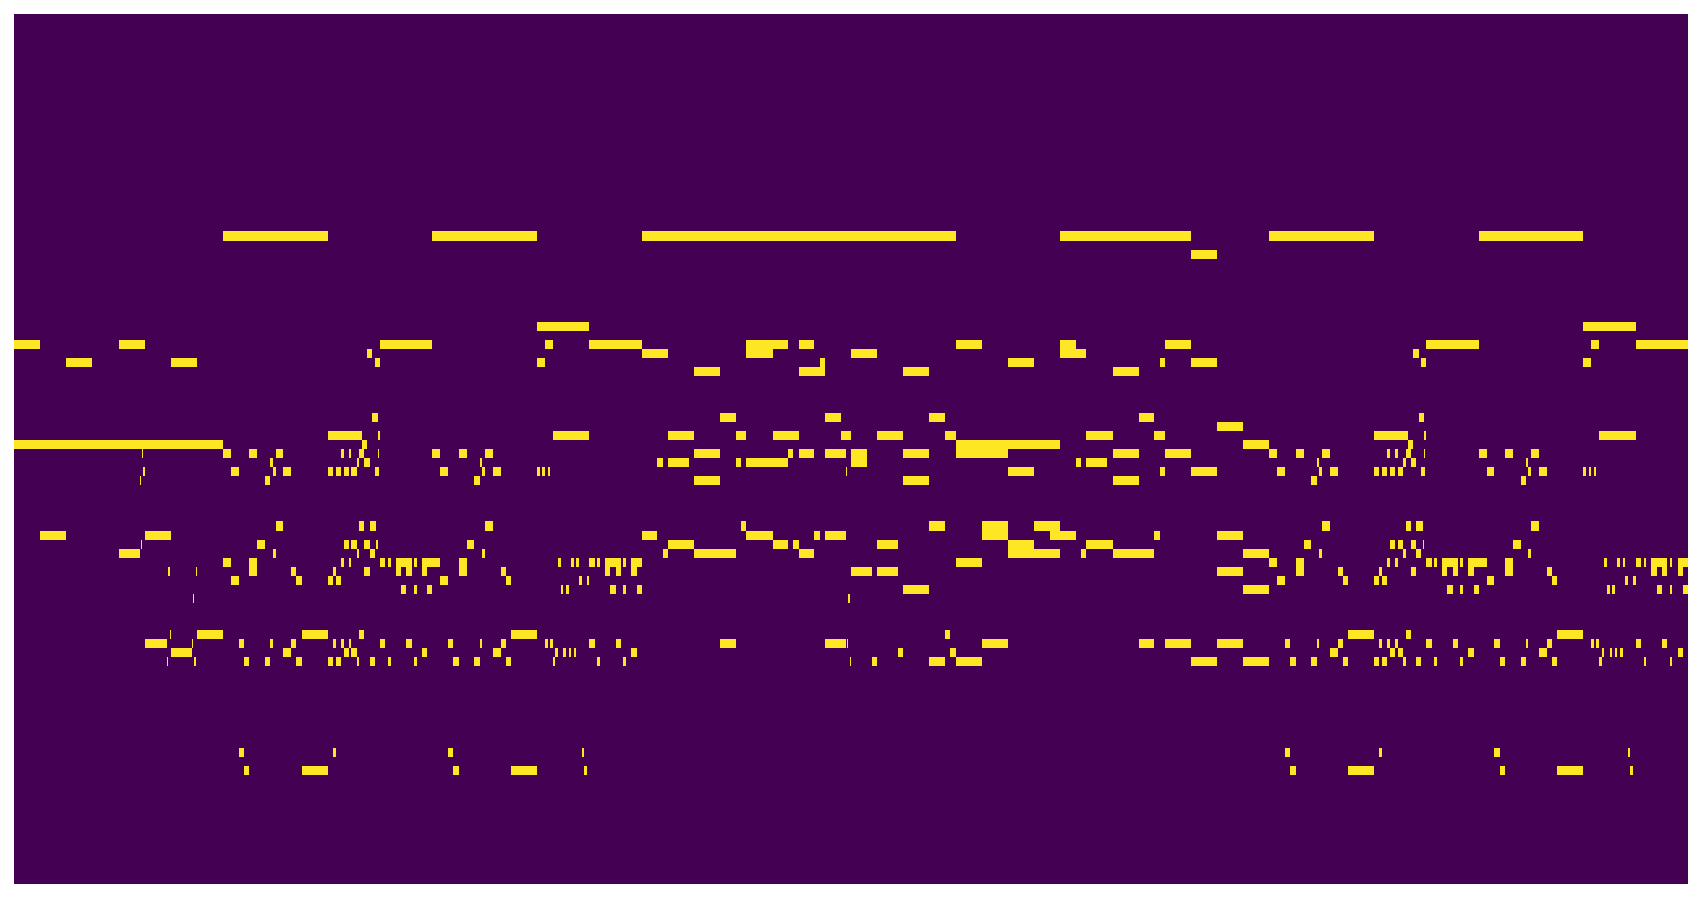

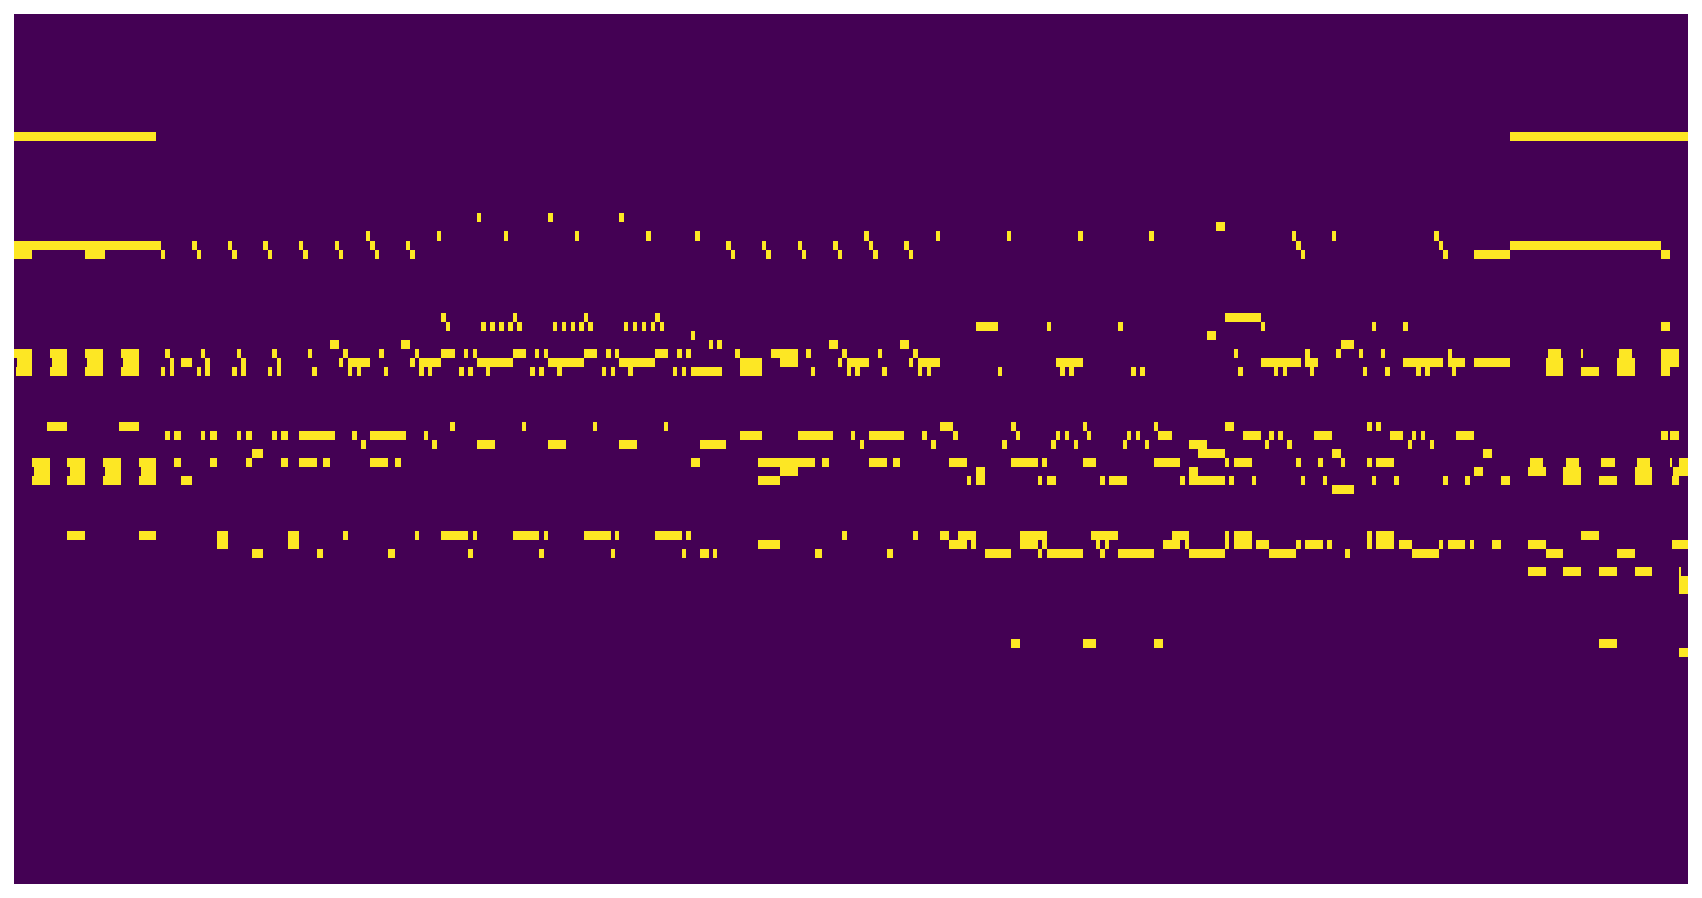

In [45]:
idx_all=np.arange(len(grid_out))
num_plot=10
for i in range(num_plot):
    idx=int(np.random.choice(idx_all,size=1))
    plt.imshow(grid_out[idx],extent=[-10,10,-1,1],aspect='auto')
    plt.axis('off')
    plt.show()

# OK so we have 91 songs for training

Now we just need to do a bit more manipulating to make them into the right shape

(row,column,channel)

In [48]:
print(grid_out[0].shape)
print(grid_out[1].shape)
print(image_width*num_channels)

(96, 1536)
(96, 5904)
384


In [49]:
samples=0
for i in range(len(grid_out)):
    
    images=math.floor(grid_out[i].shape[1]/(image_width))
    samples+=images-(num_channels-1) #the total amount of training data we can have by striding by 1
    
print(samples)

3012


# So for each song

- break the song up into images
- create training data by stacking num_channels images together and then striding by 1

In [50]:
ins=np.zeros((samples,image_height,image_width,num_channels))
print(ins.shape)

sample_idx=-1

for i in range(len(grid_out)):
    
    num_images=math.floor(grid_out[i].shape[1]/(image_width))
    num_samples=num_images-(num_channels-1)
    
    images=np.zeros((image_height,image_width,num_images))
    
    for j in range(num_images):
        
        left_idx=0+j*image_width
        right_idx=image_width+j*image_width
        images[:,:,j]=grid_out[i][:,left_idx:right_idx]
        
    for k in range(num_samples):
        sample_idx+=1
        
        left_idx=k
        right_idx=k+num_channels
    
        ins[sample_idx,:,:,:]=images[:,:,left_idx:right_idx]
        
        
        
        
        
        

(3012, 96, 96, 4)


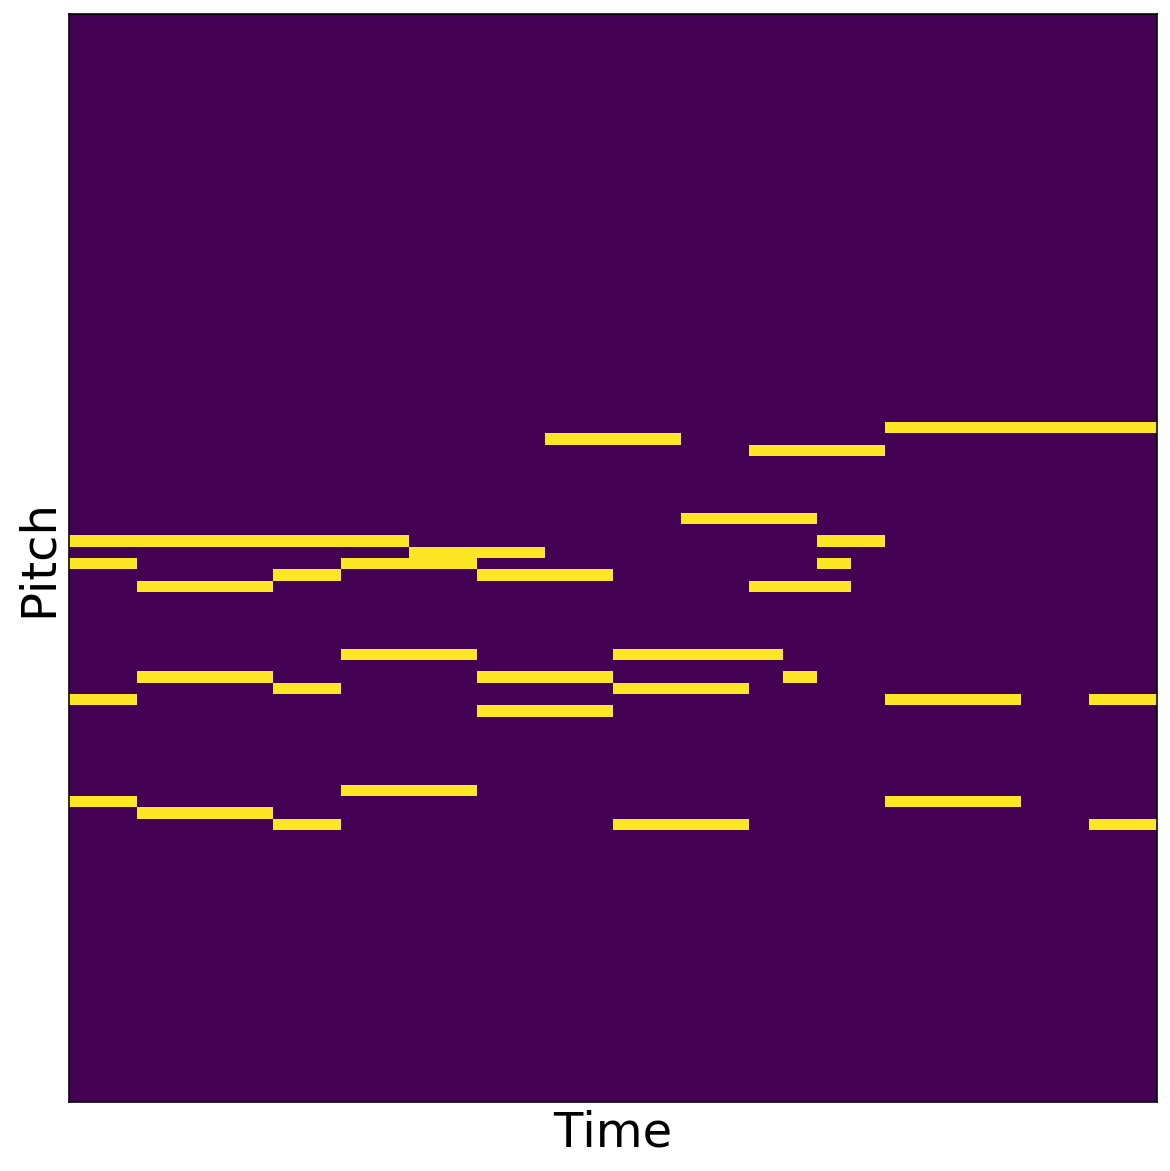

In [52]:
plt.rcParams['figure.figsize']=(10,10)
idx_all=np.arange(ins.shape[0])
image_idx=np.random.choice(idx_all,replace=False,size=1)
plt.imshow(ins[image_idx,:,:,0].reshape(96,96))
plt.xticks(ticks=[],labels=[])
plt.yticks(ticks=[],labels=[])
plt.xlabel('Time')
plt.ylabel('Pitch')
plt.savefig('./plots/training_data_single_measure_fifths.png',bbox_inches='tight')

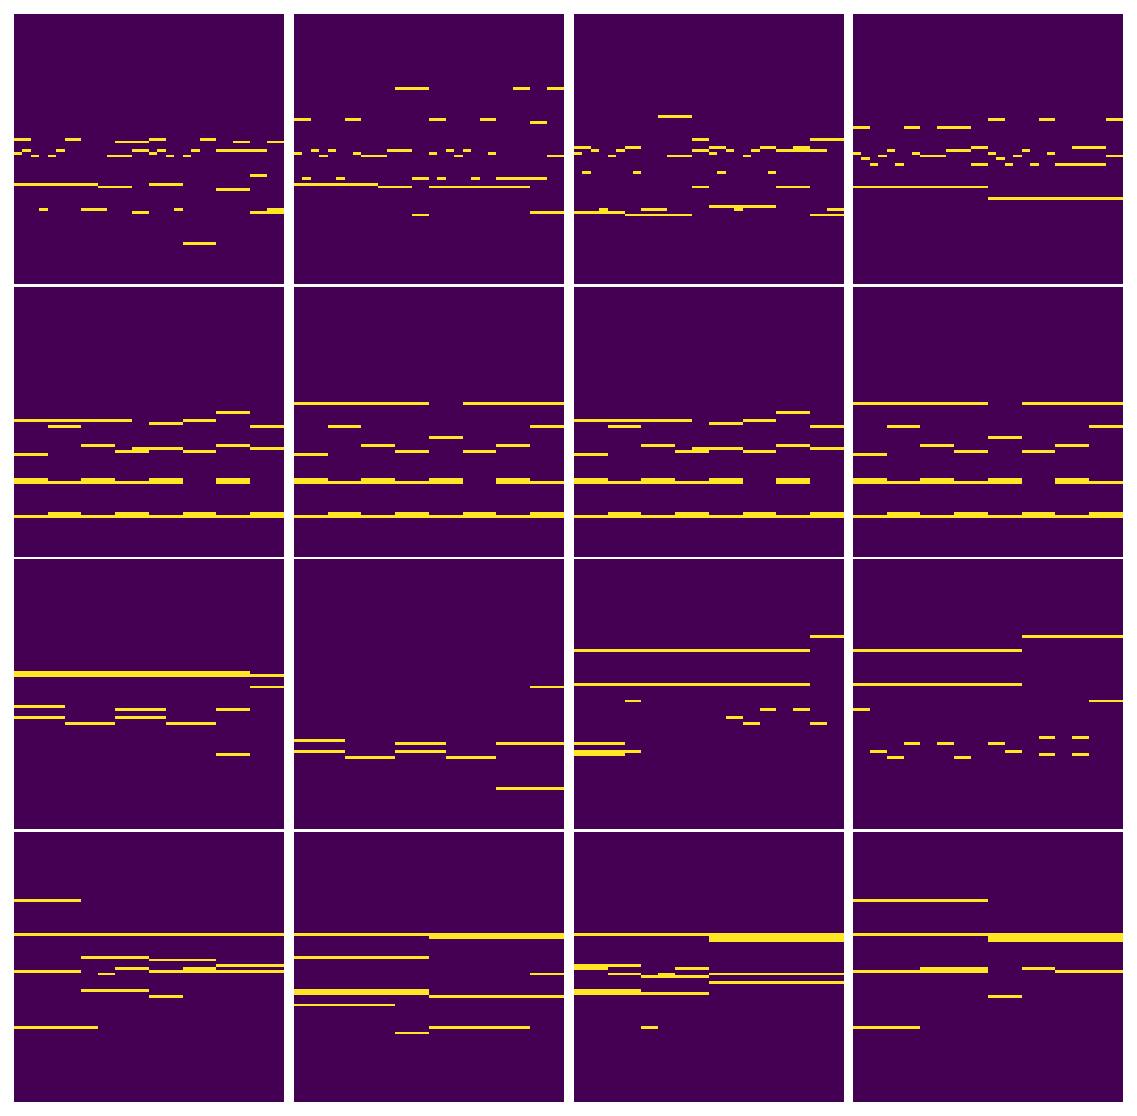

In [55]:
plt.rcParams['figure.figsize']=(10,10)
idx=54
fig,axs=plt.subplots(4,4)
idx_all=np.arange(ins.shape[0])
image_idxs=np.random.choice(idx_all,replace=False,size=4)

for i in range(4):
    for j in range(4):
        
        axs[i,j].imshow(ins[image_idxs[i],:,:,j])
        axs[i,j].axis('off')
plt.subplots_adjust(wspace=0.01,hspace=0.01)
plt.savefig('./plots/training_data_fifths.png',bbox_inches='tight')



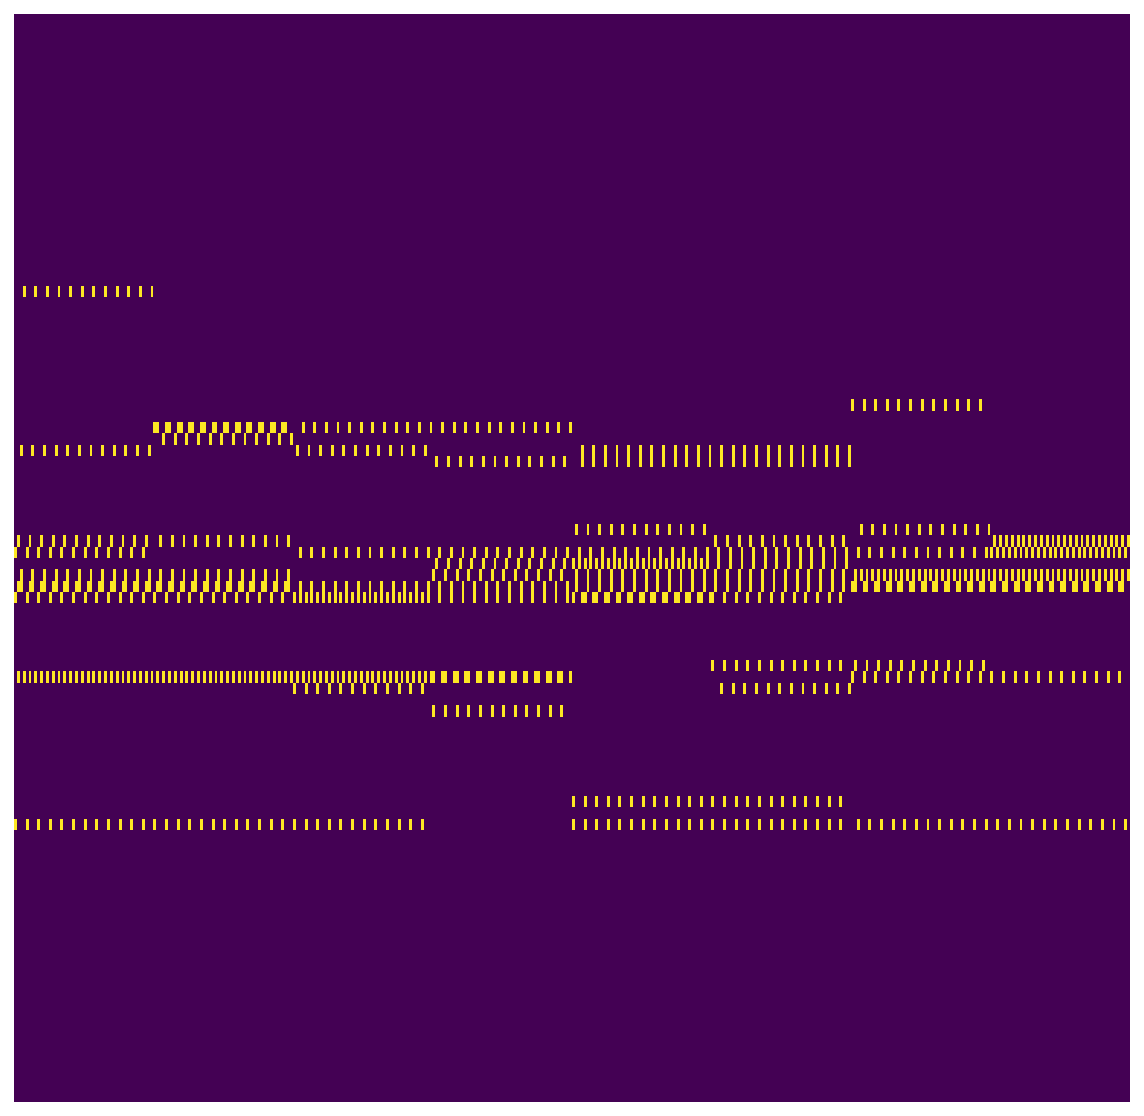

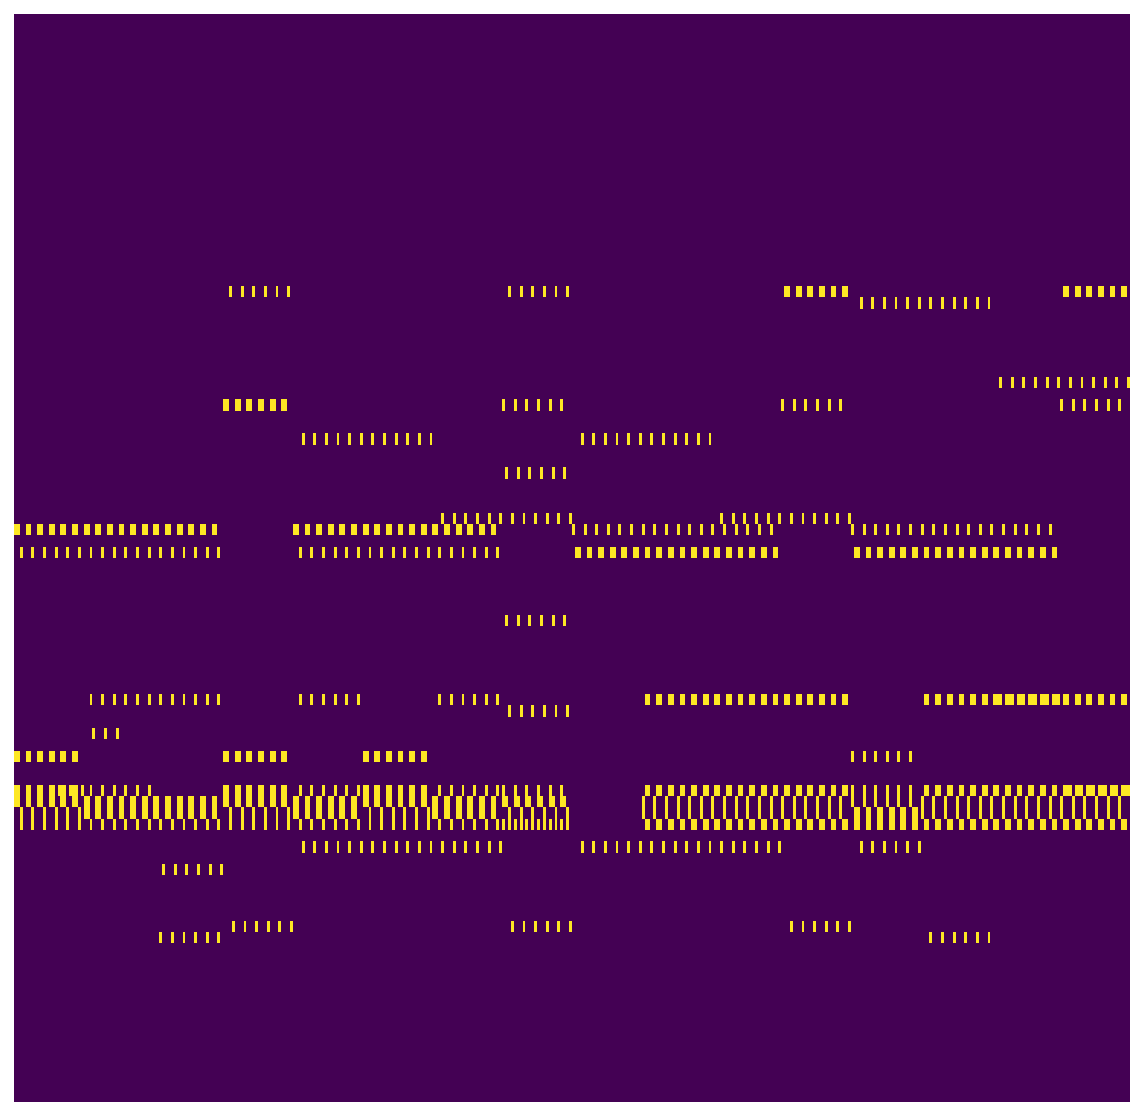

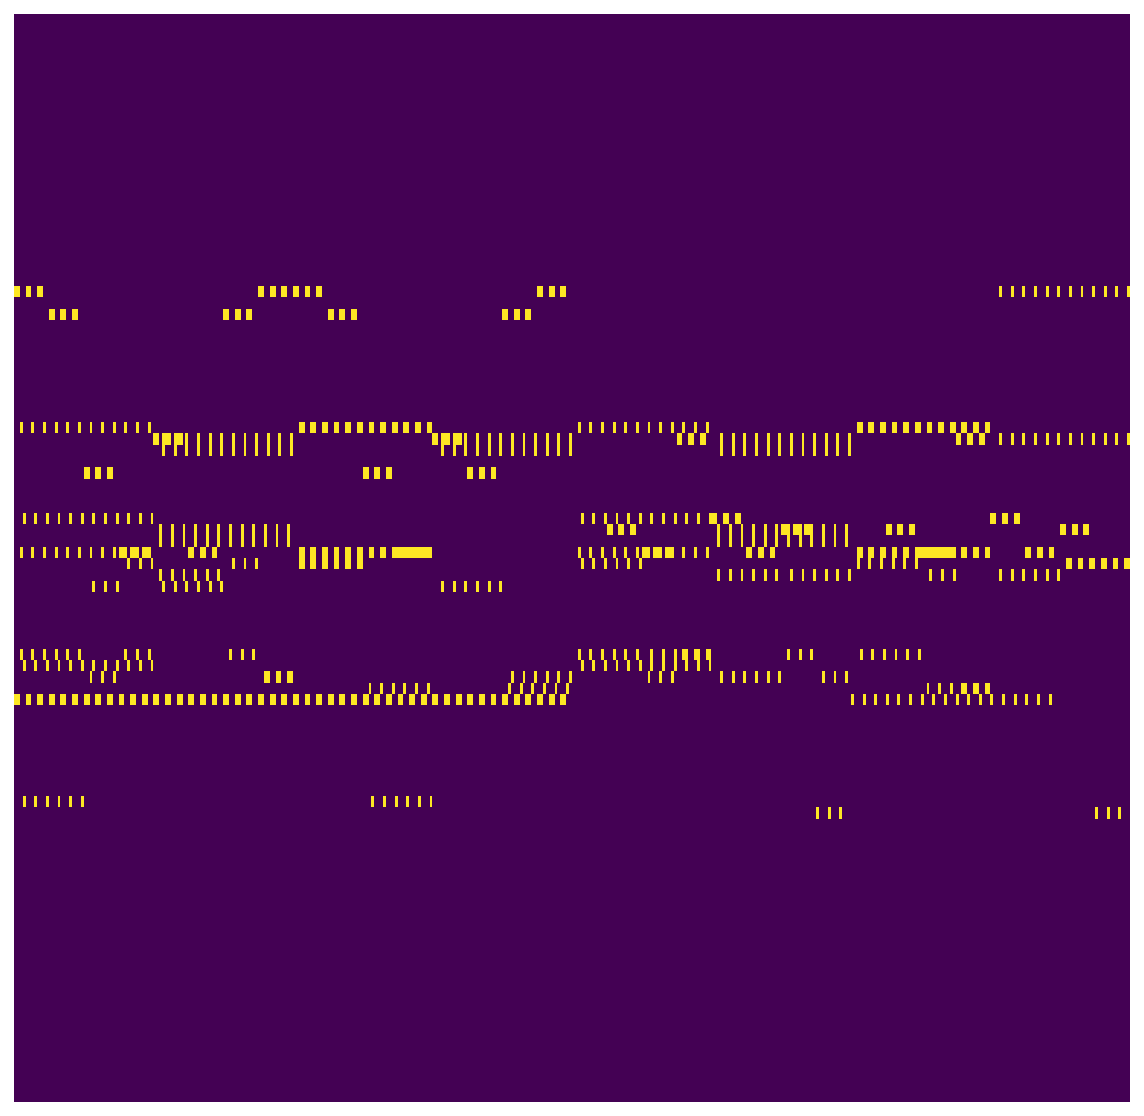

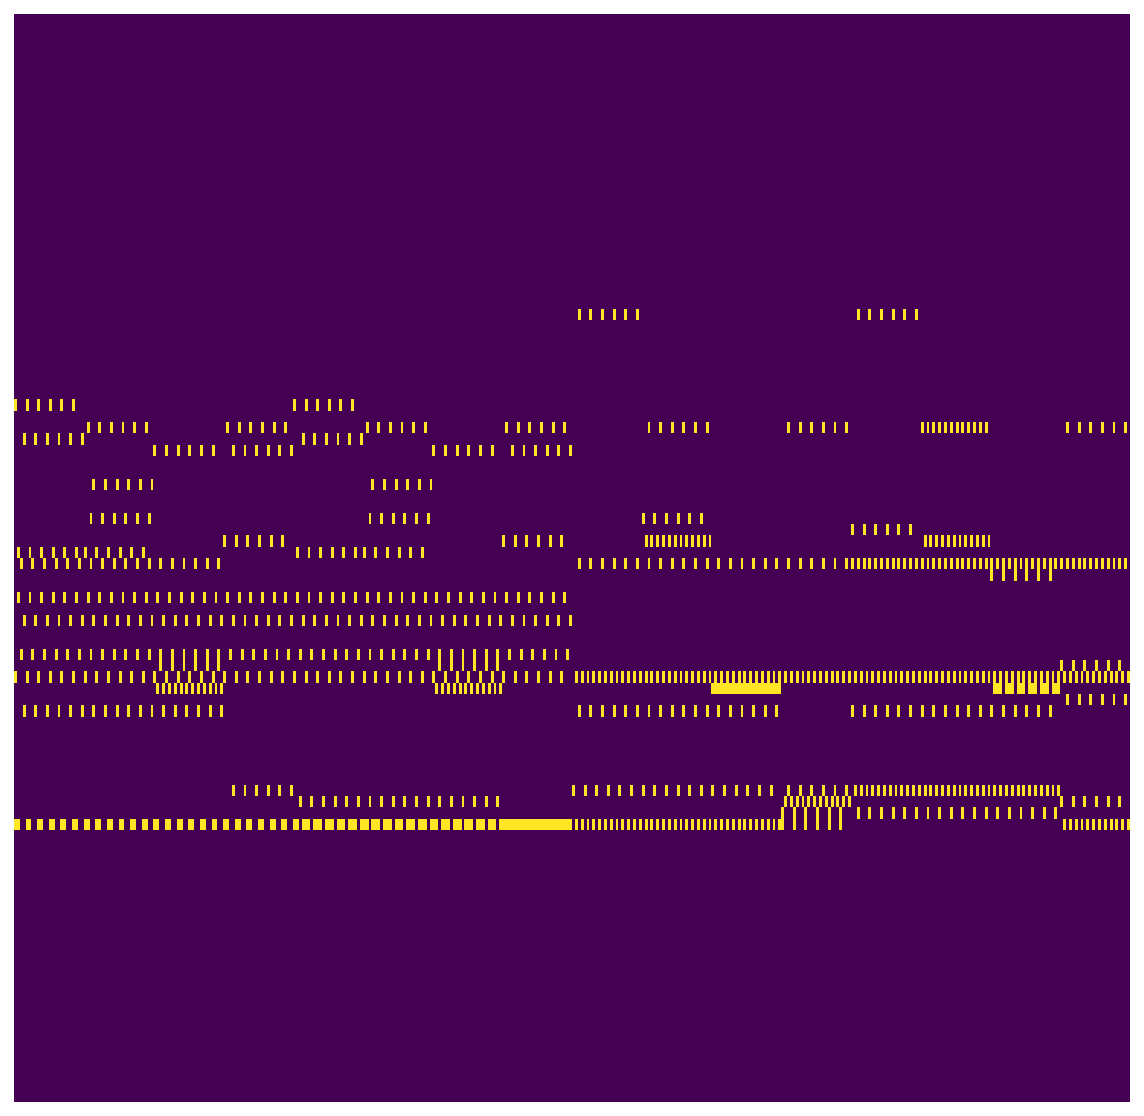

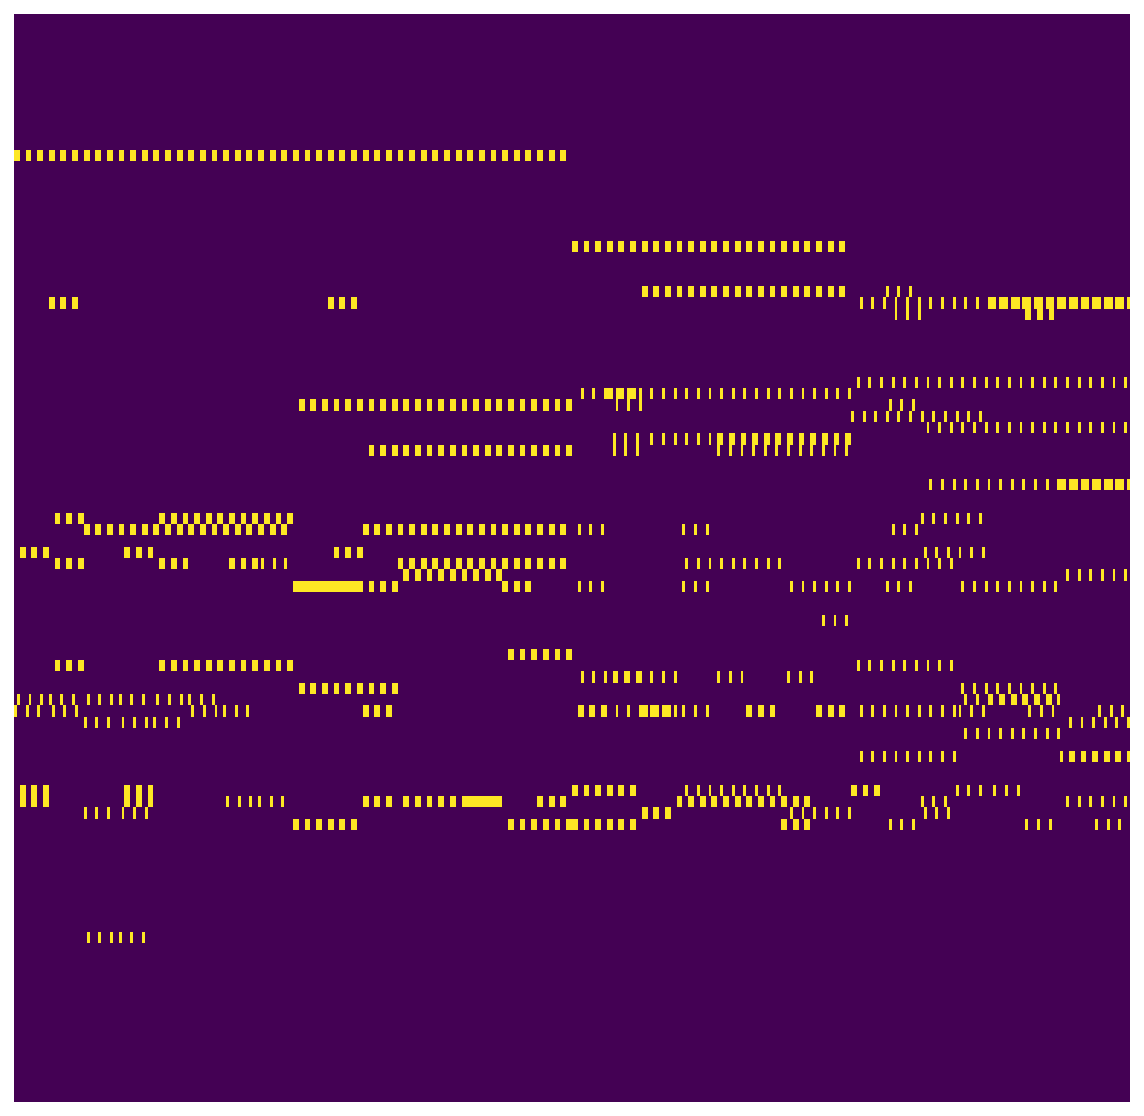

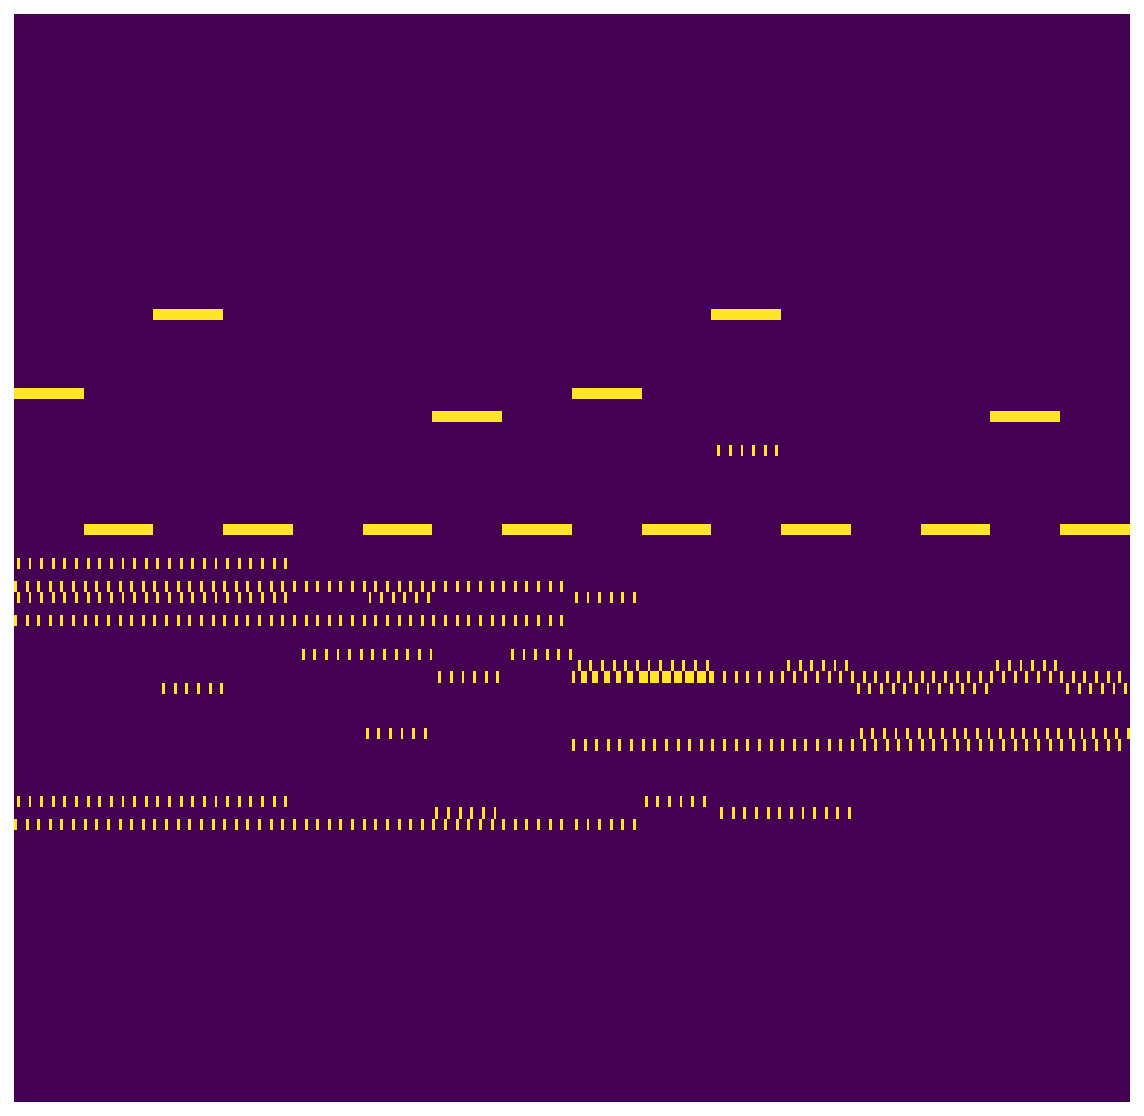

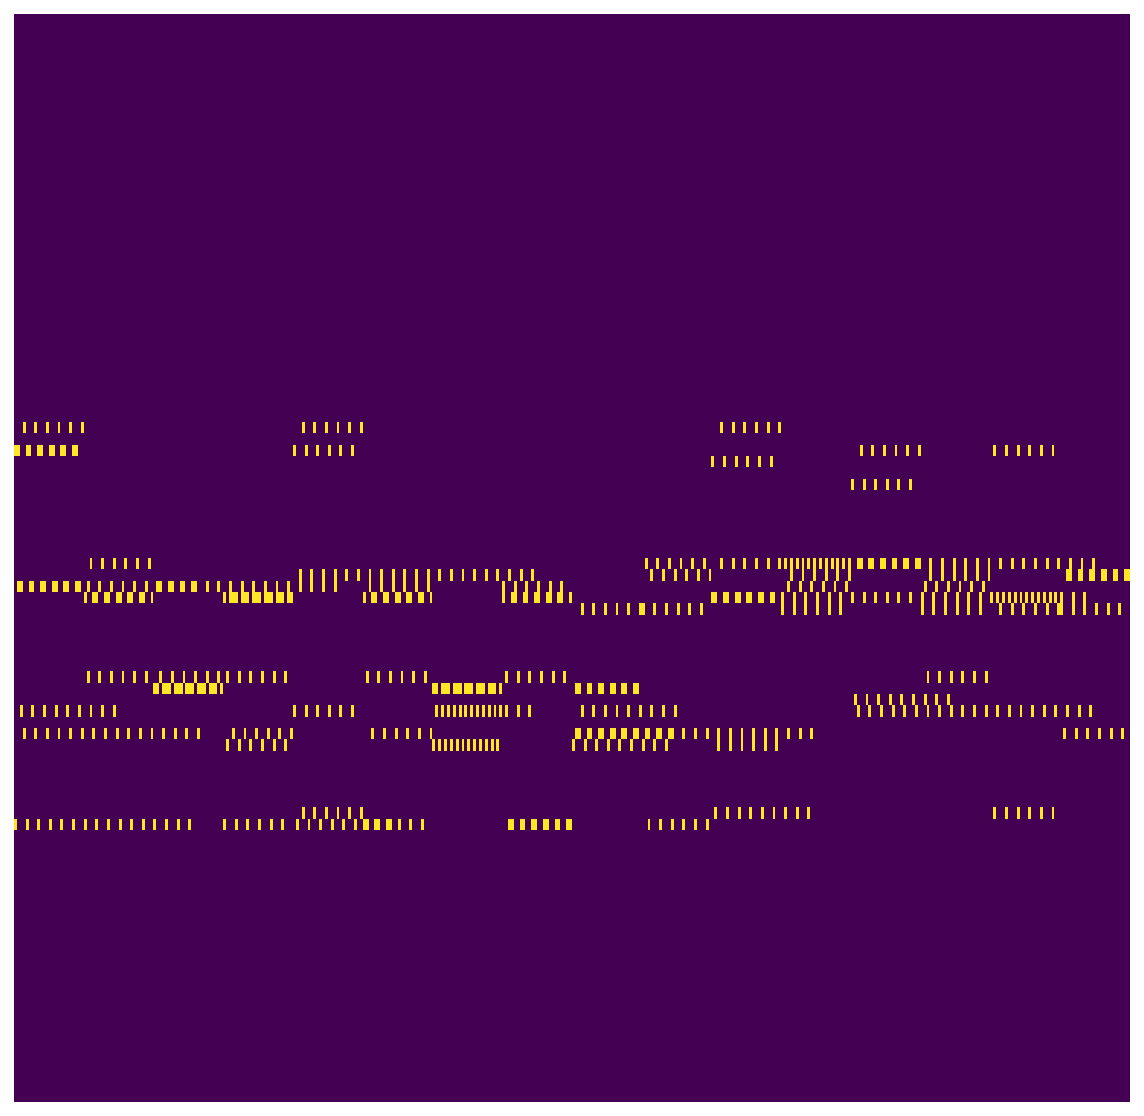

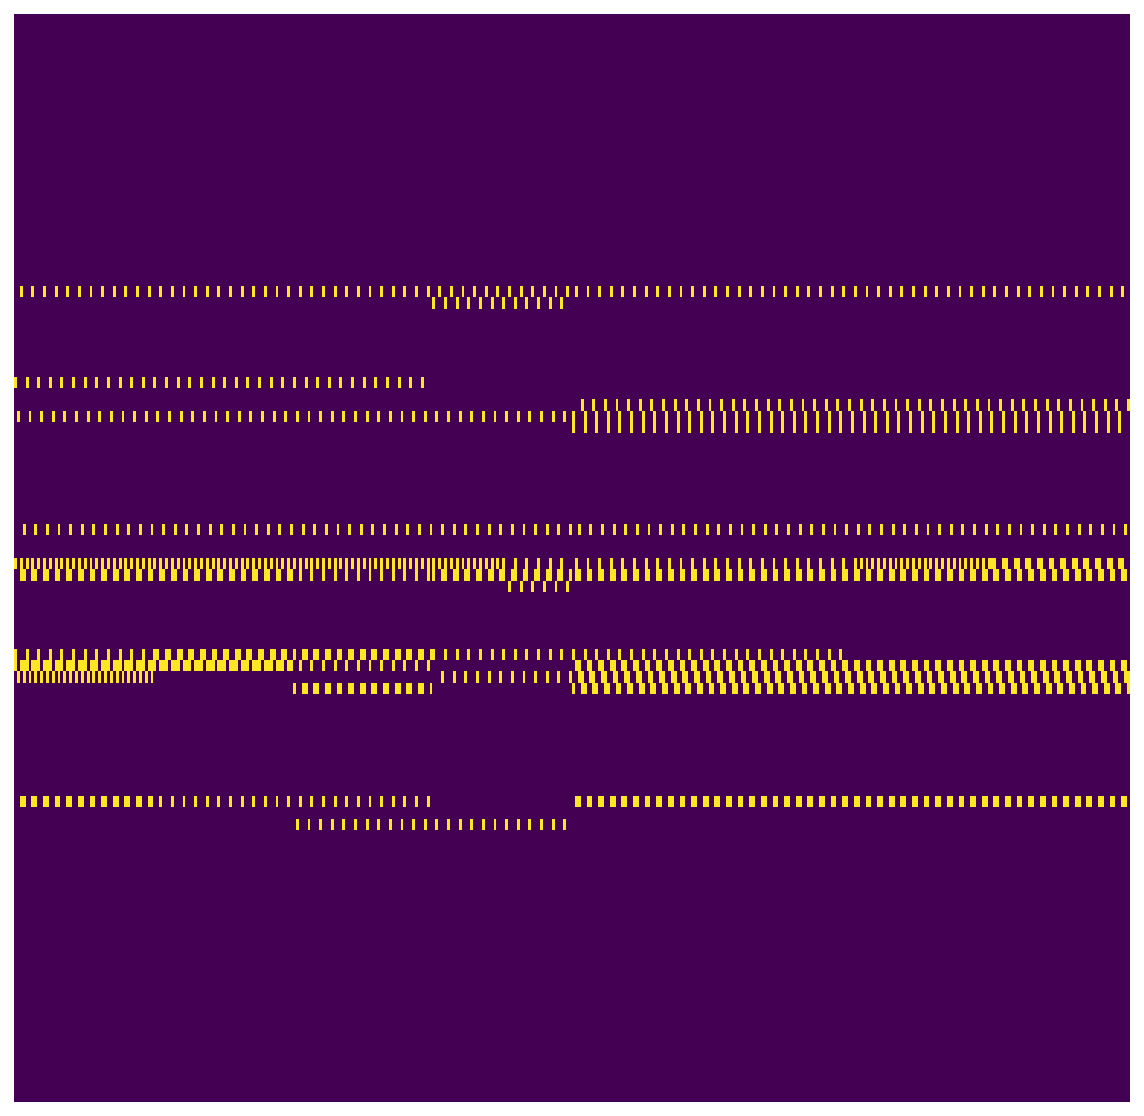

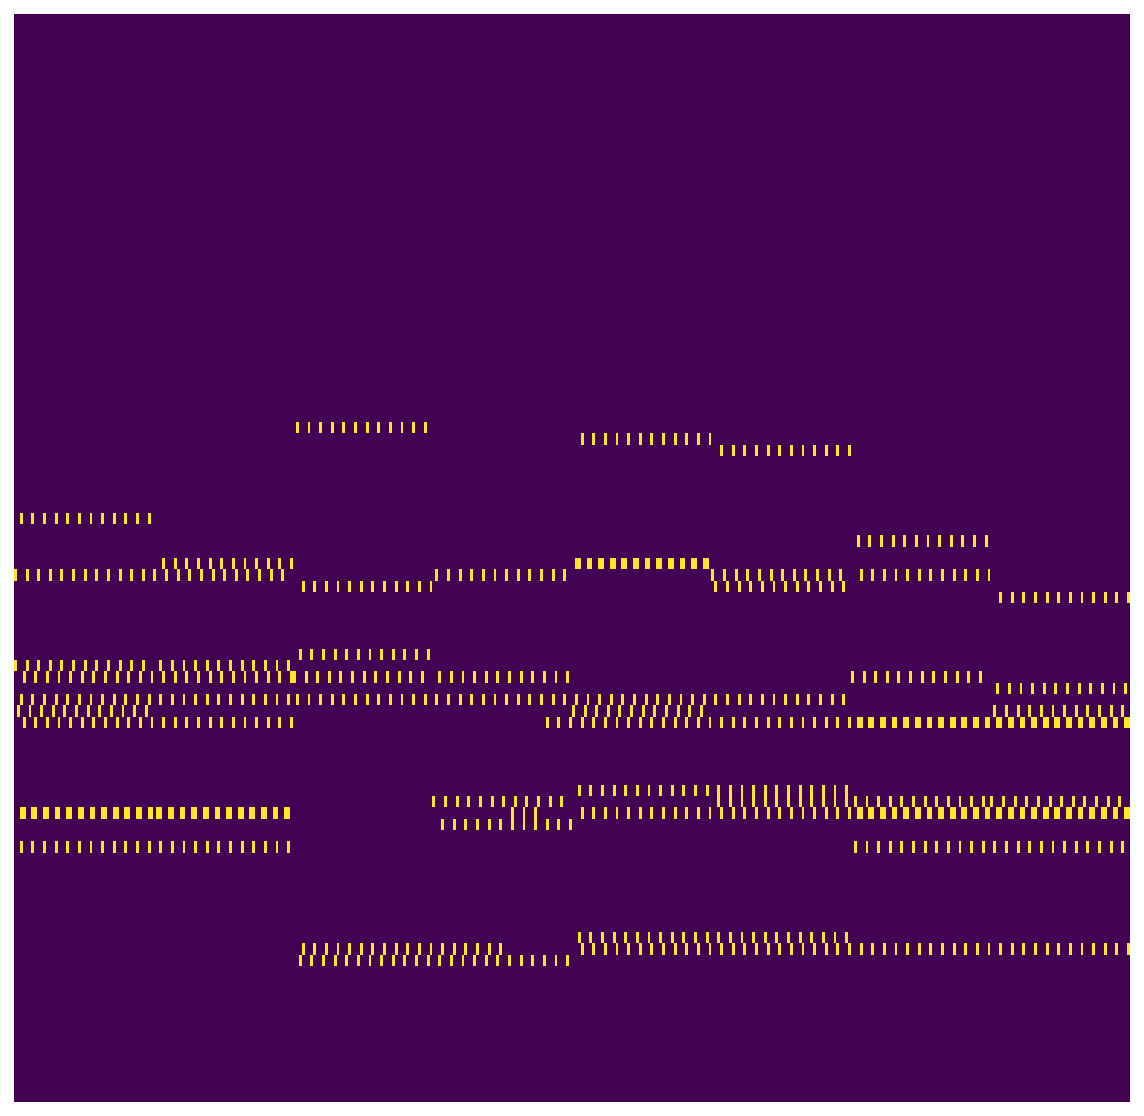

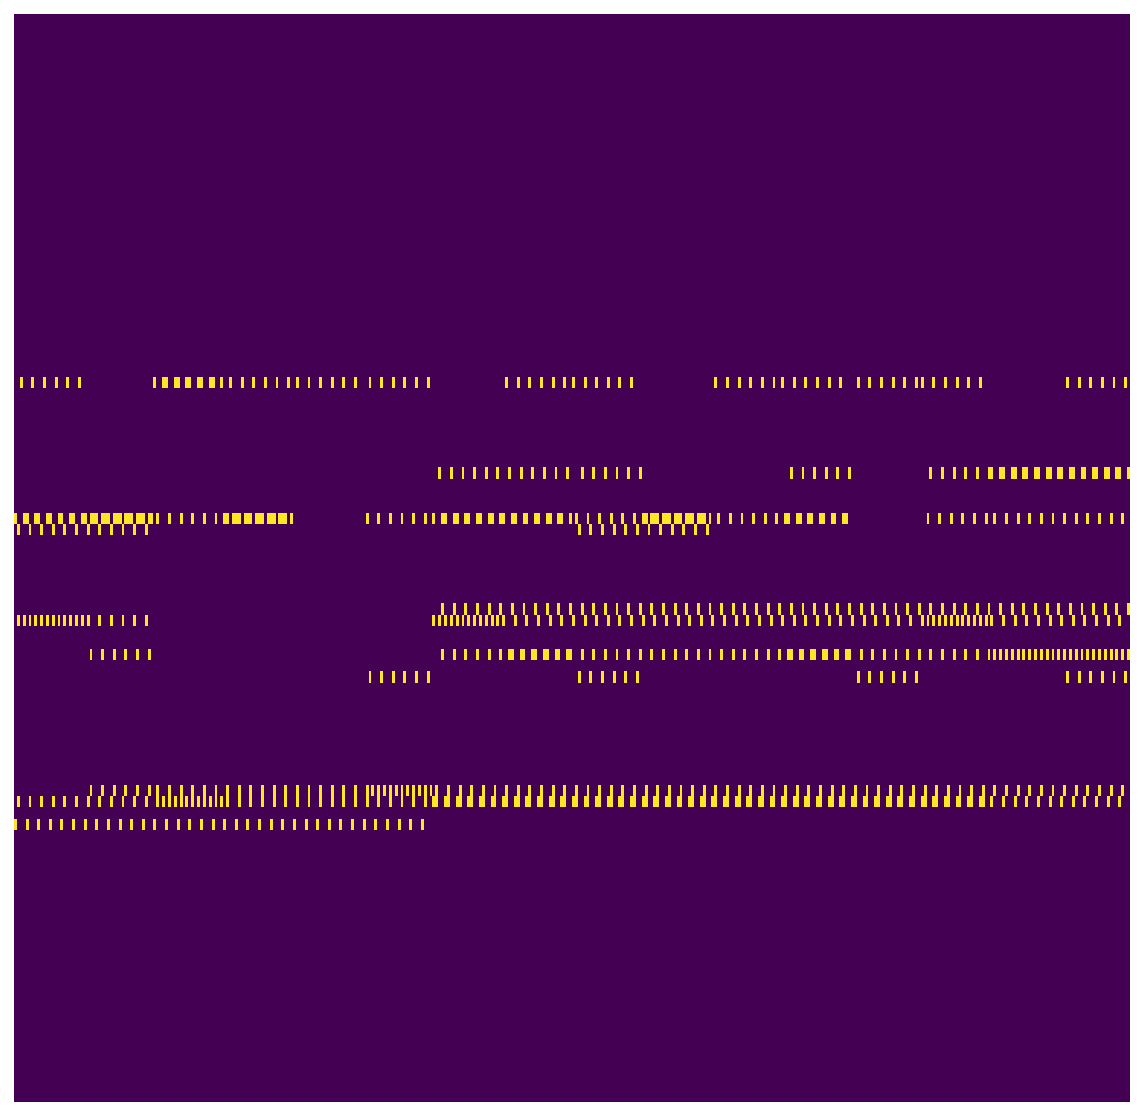

In [56]:
idx_all=np.arange(samples)
num_plot=10
for i in range(num_plot):
    
    idx=np.random.choice(idx_all,size=1)
    
    plt.imshow(ins[idx,:,:,:].reshape(image_height,image_width*num_channels),extent=[-10,10,-10,10],aspect='auto')
    plt.axis('off')
    plt.show()

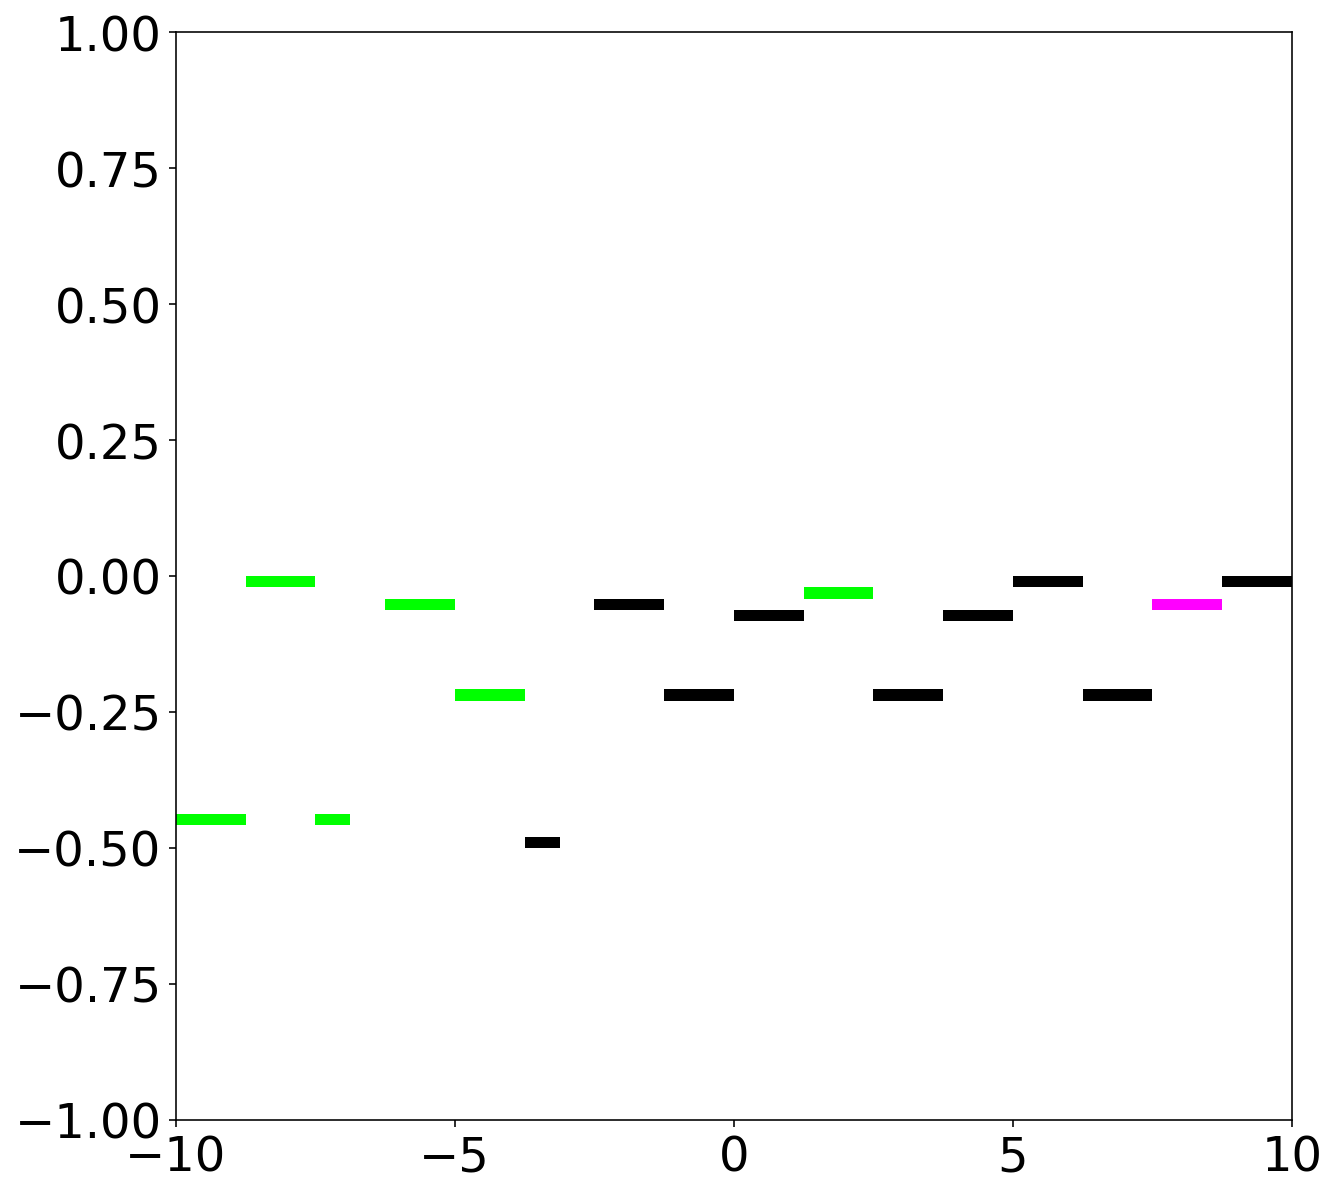

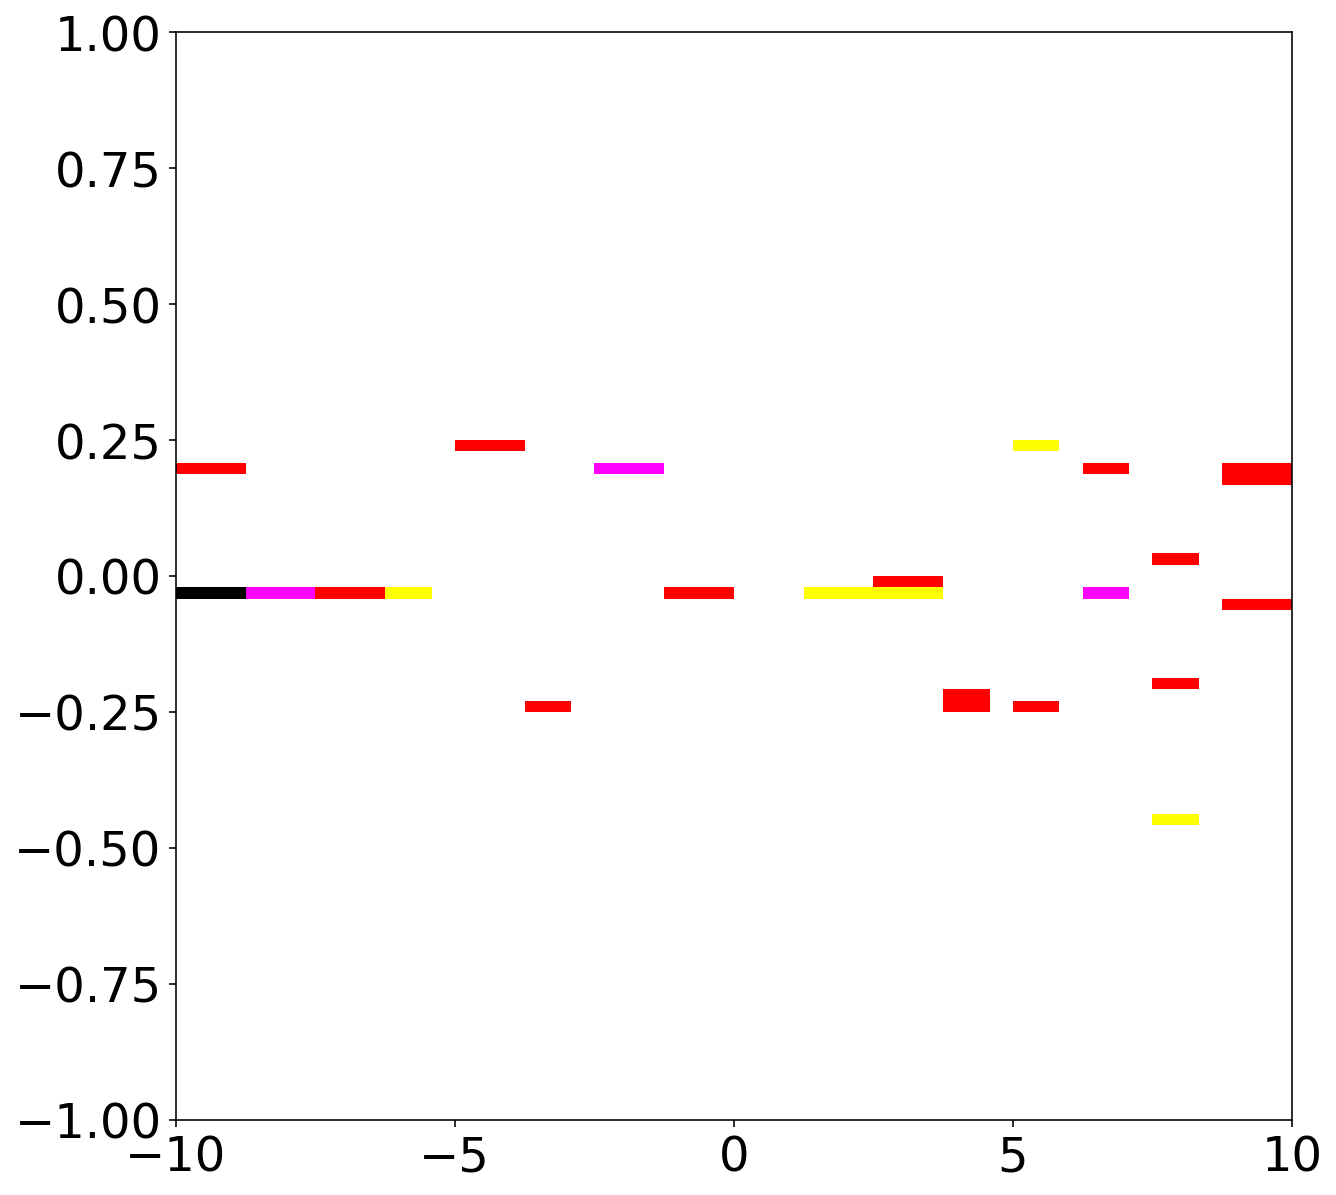

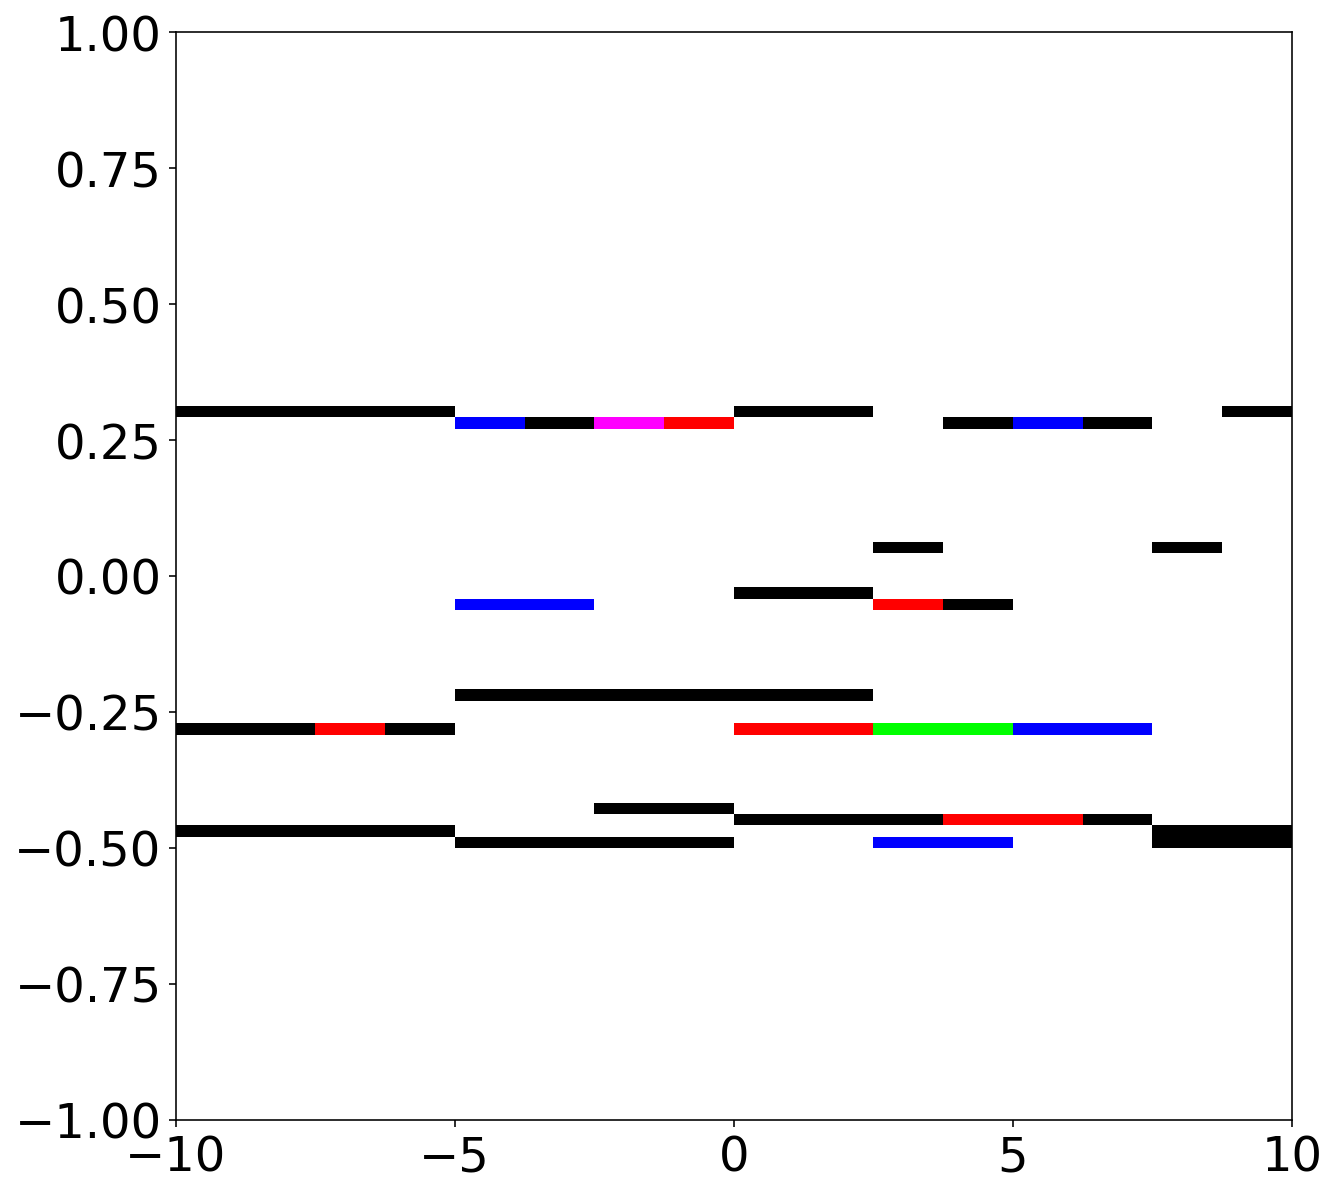

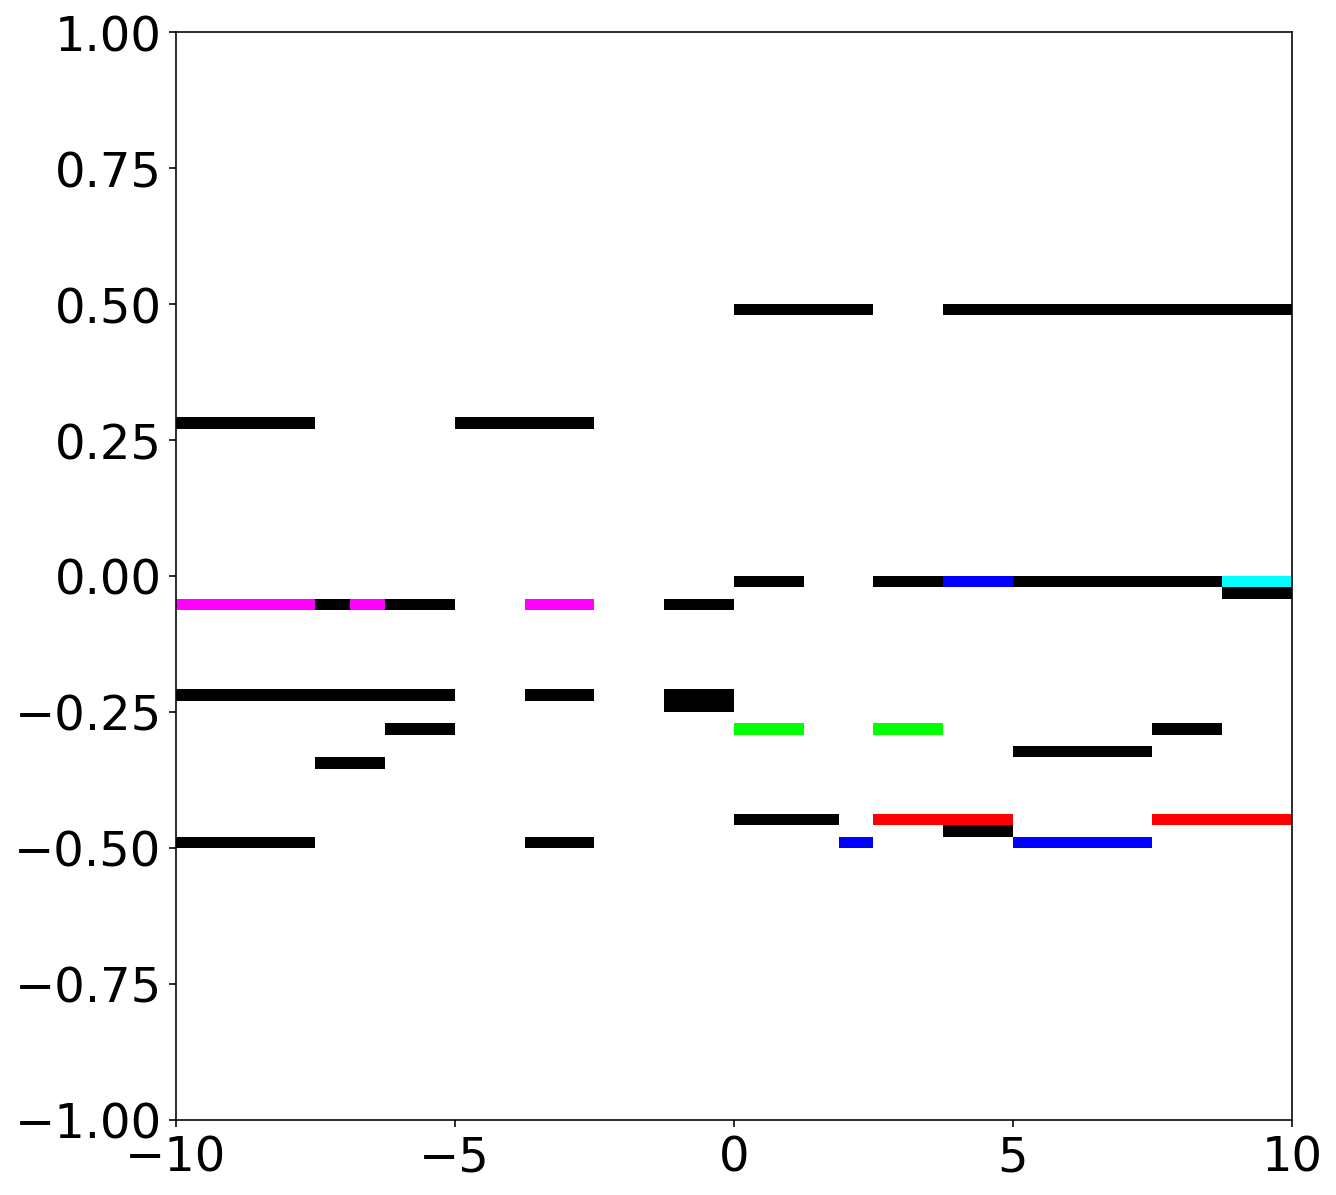

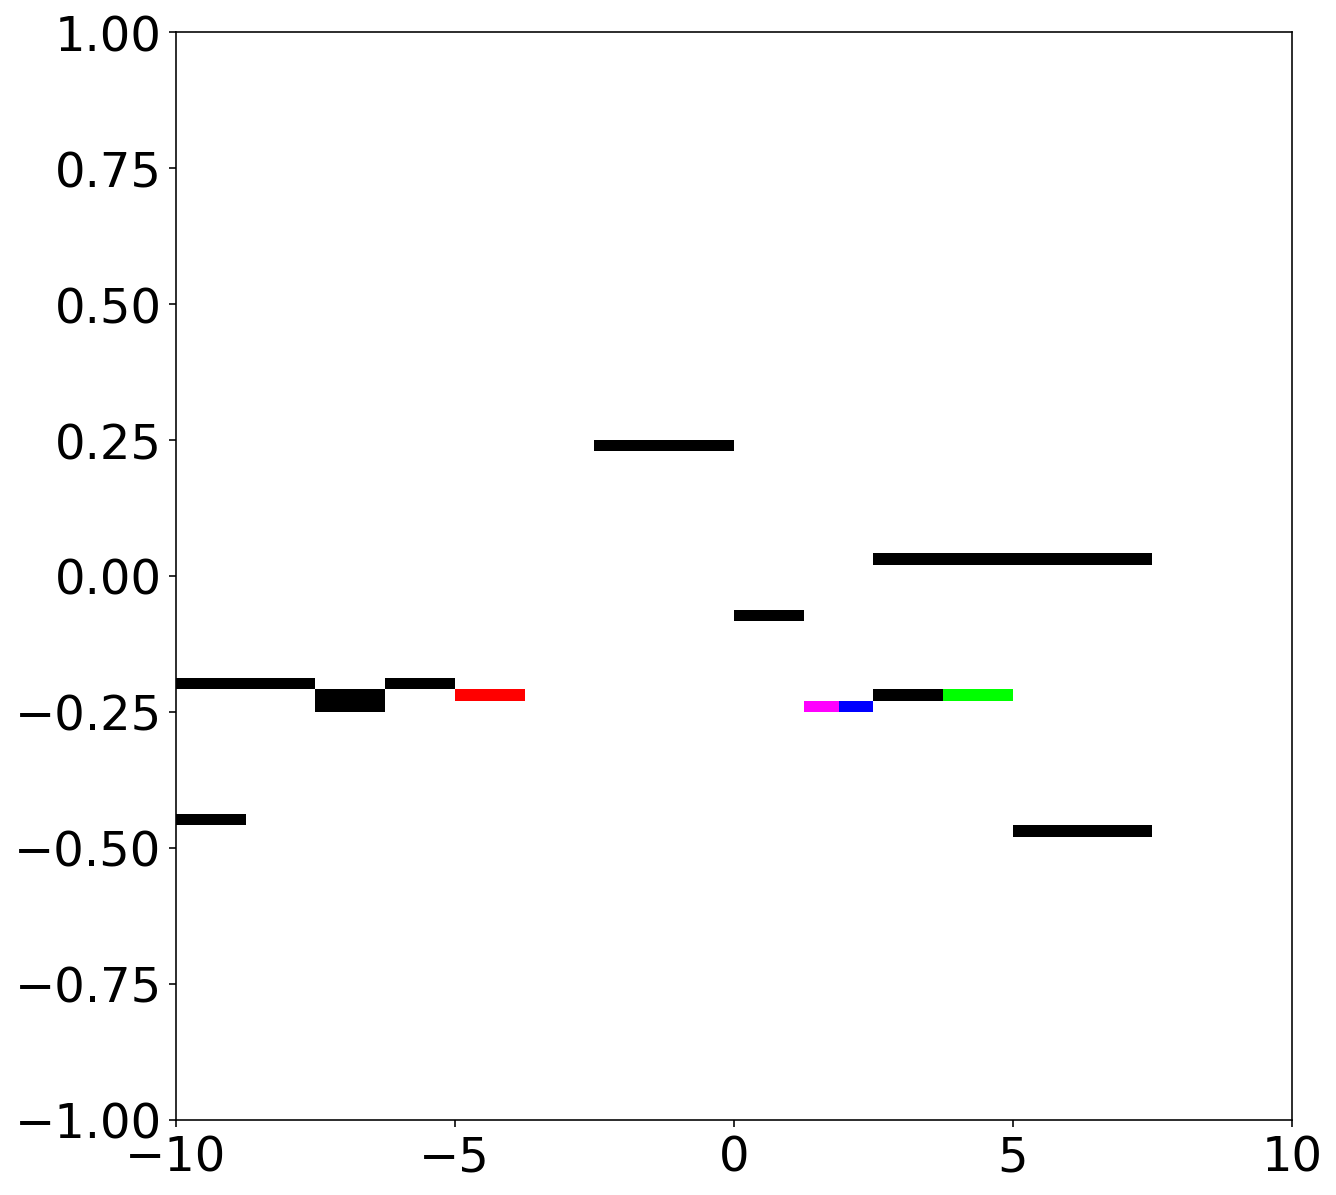

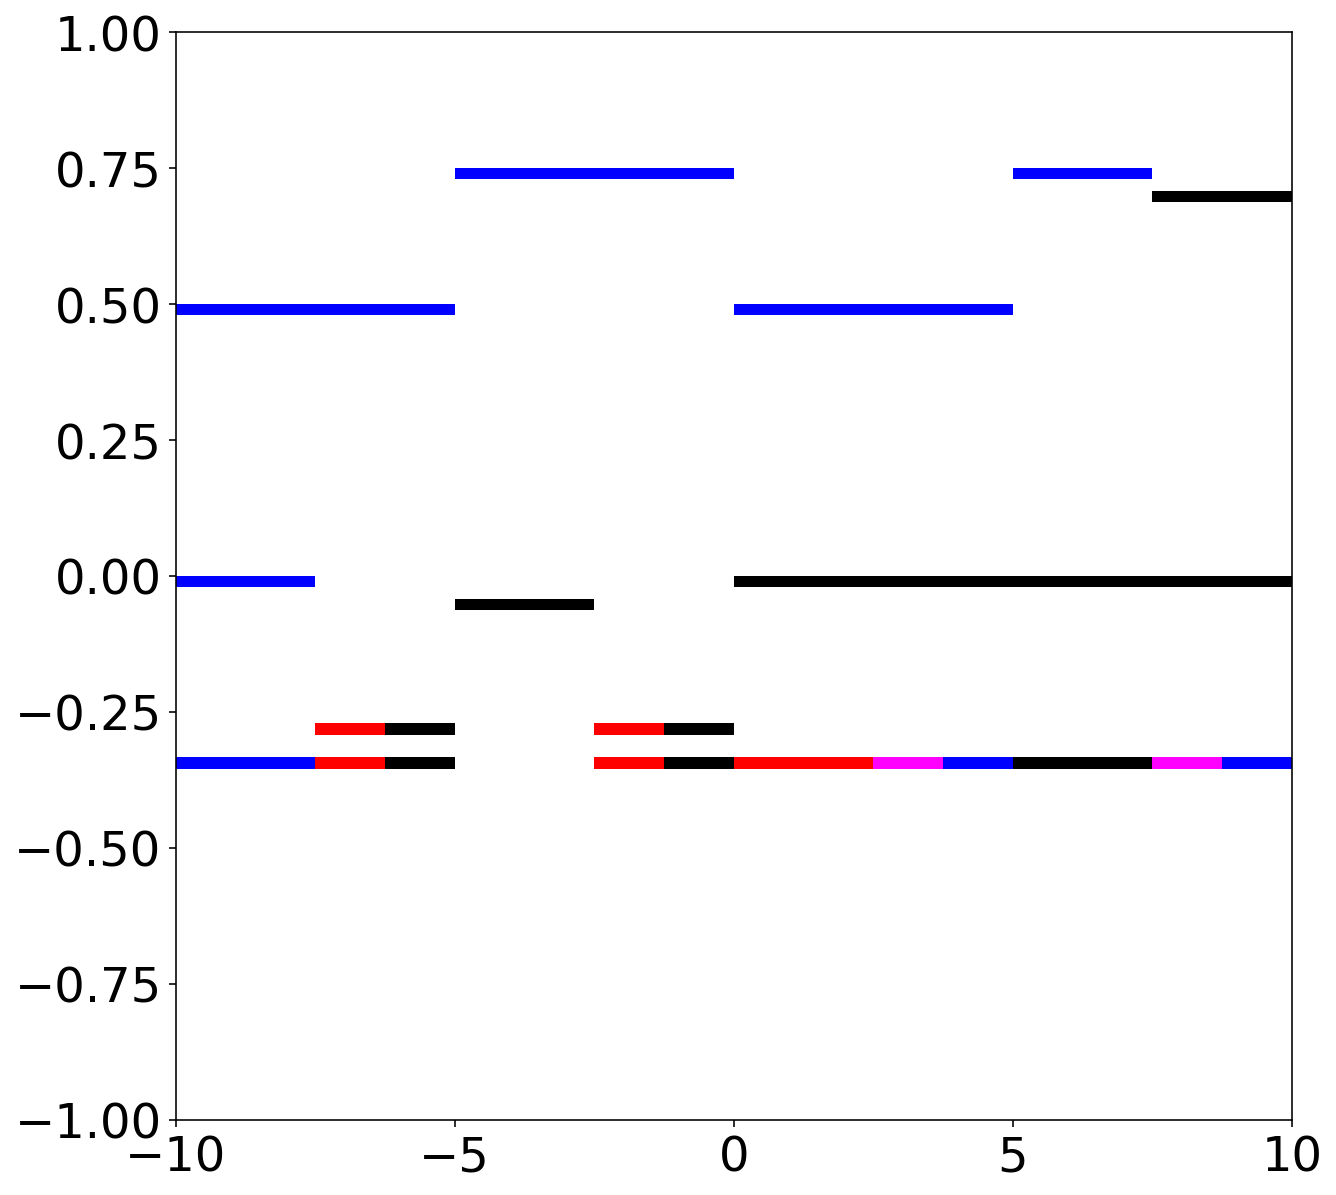

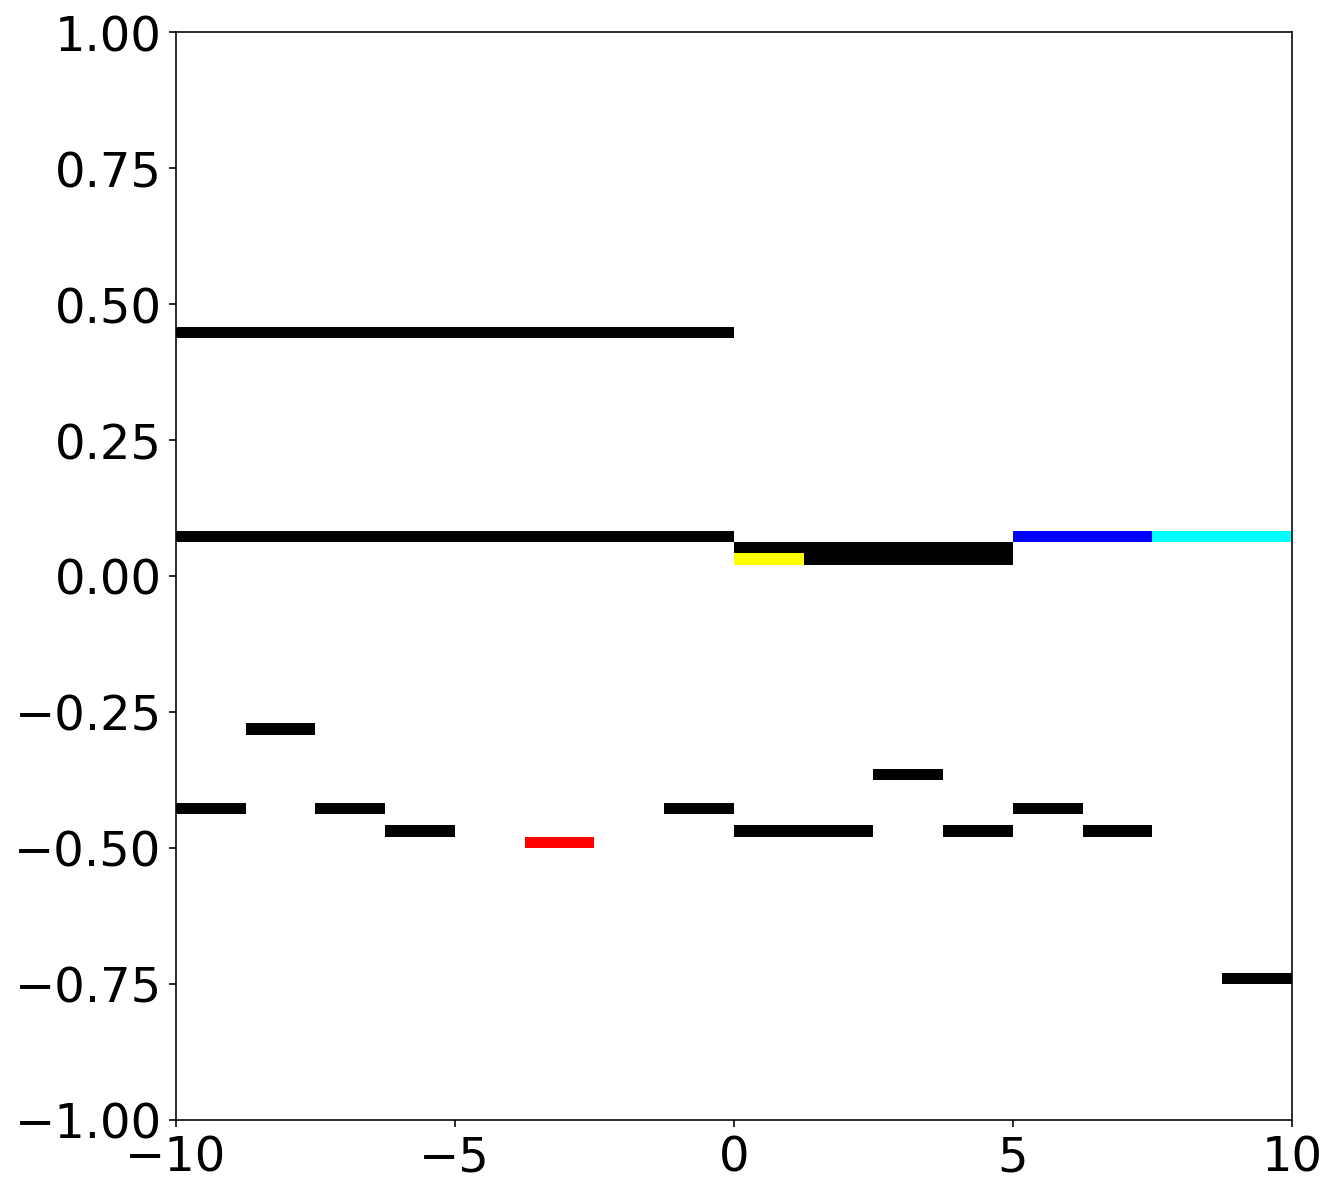

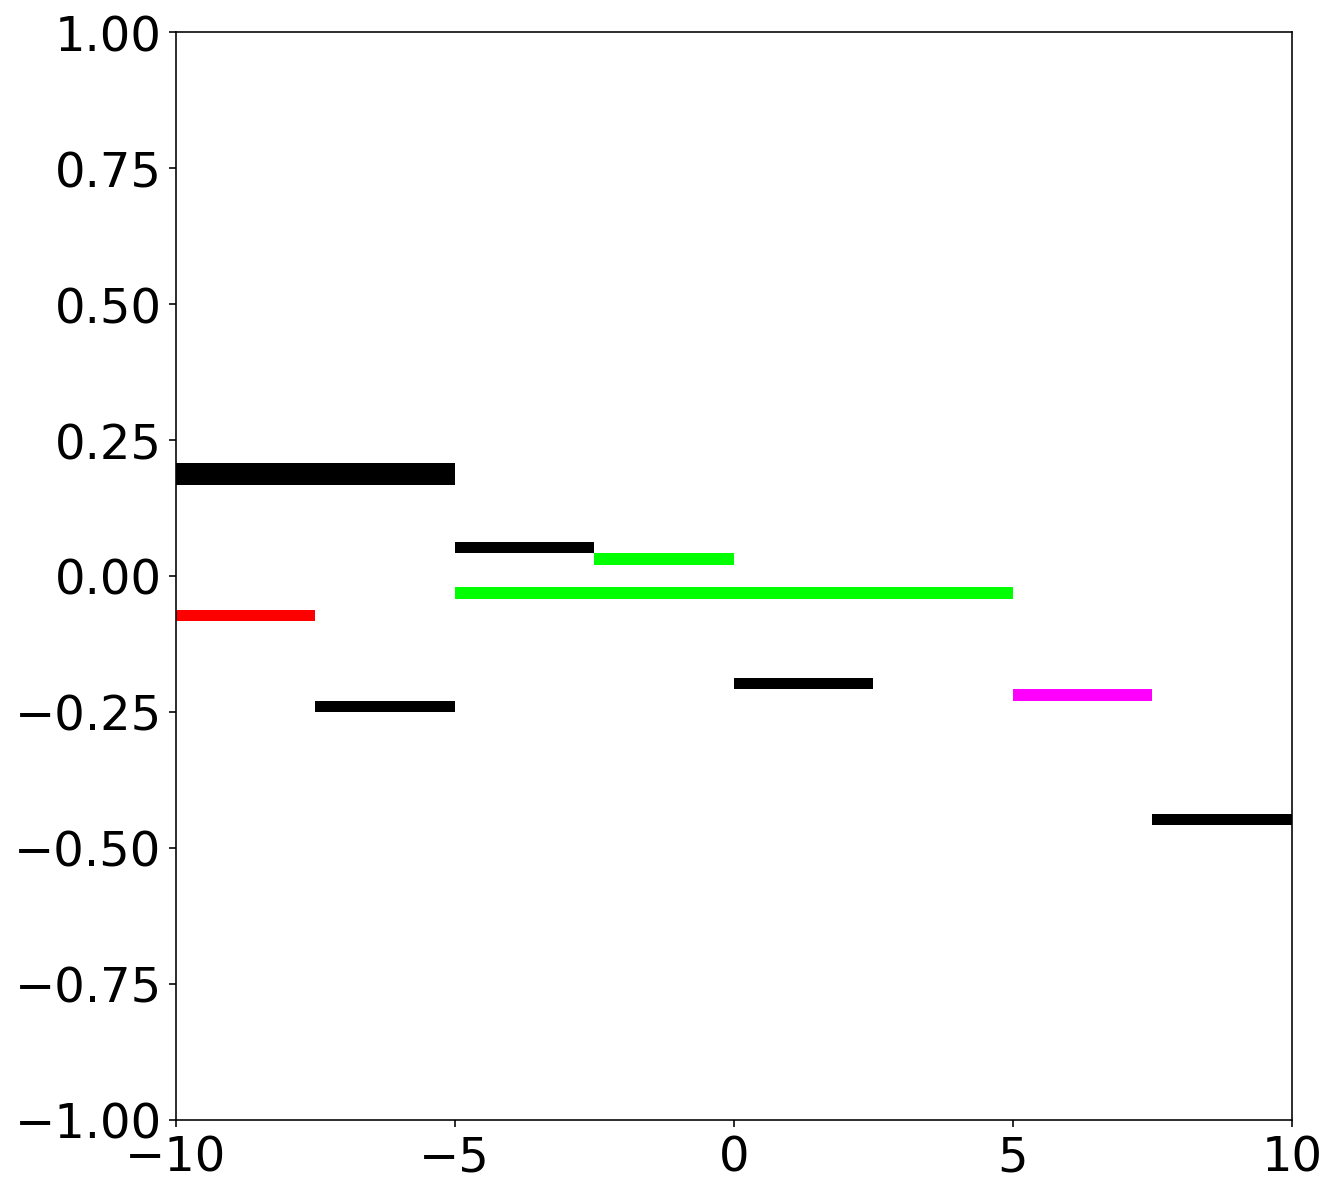

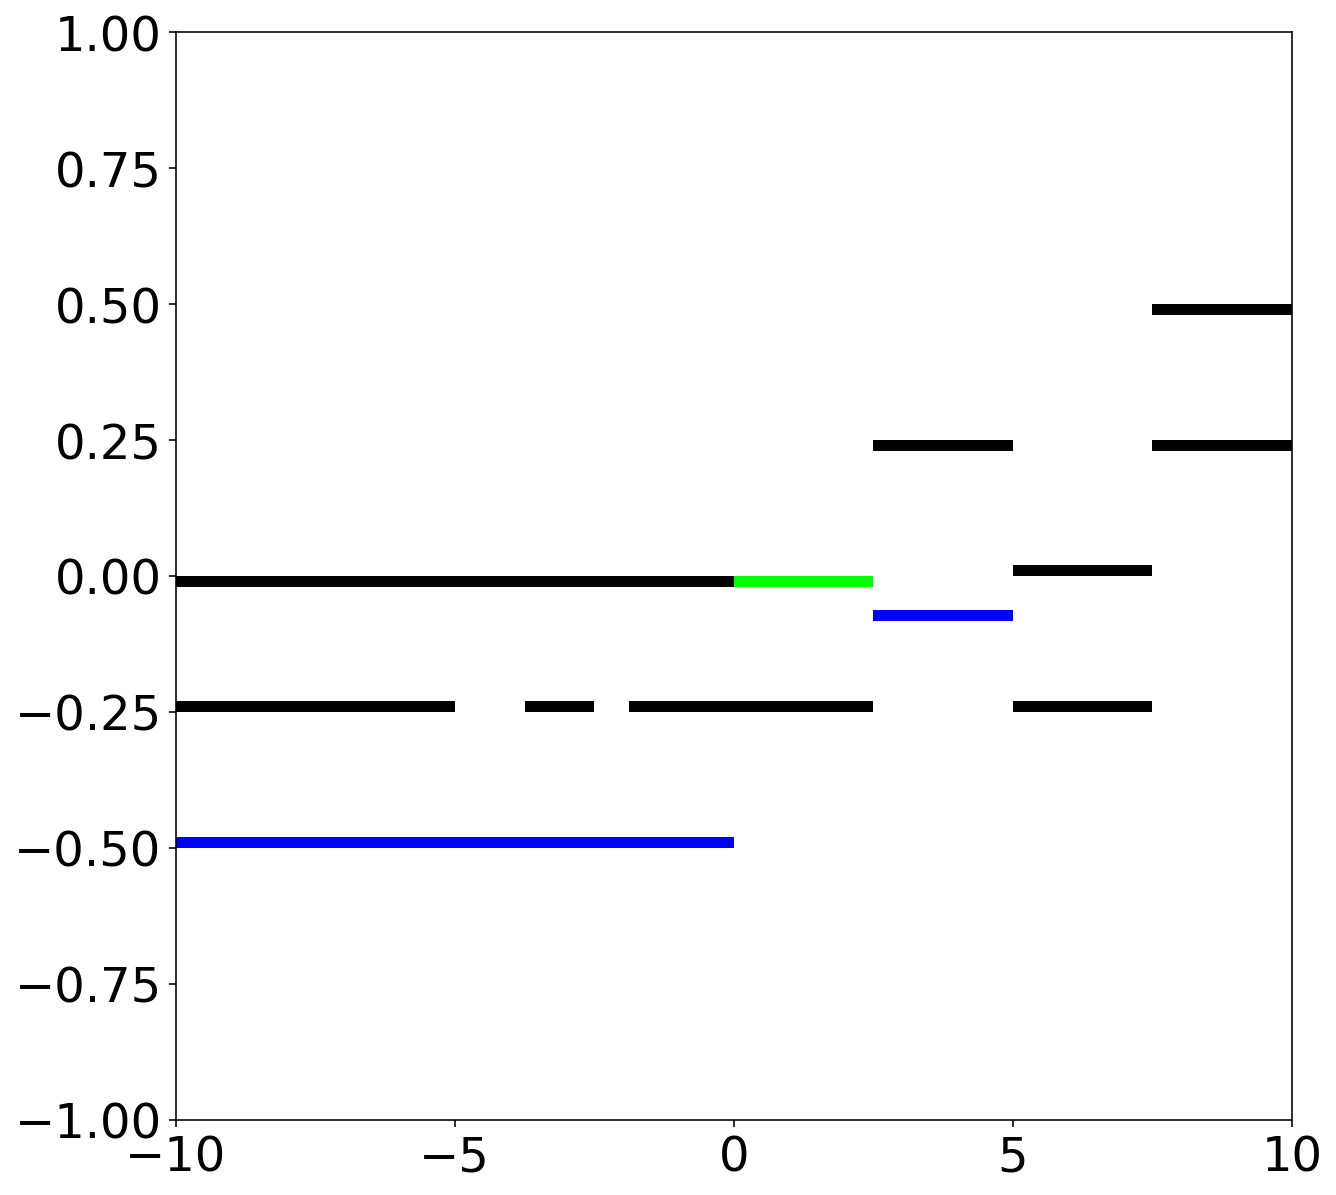

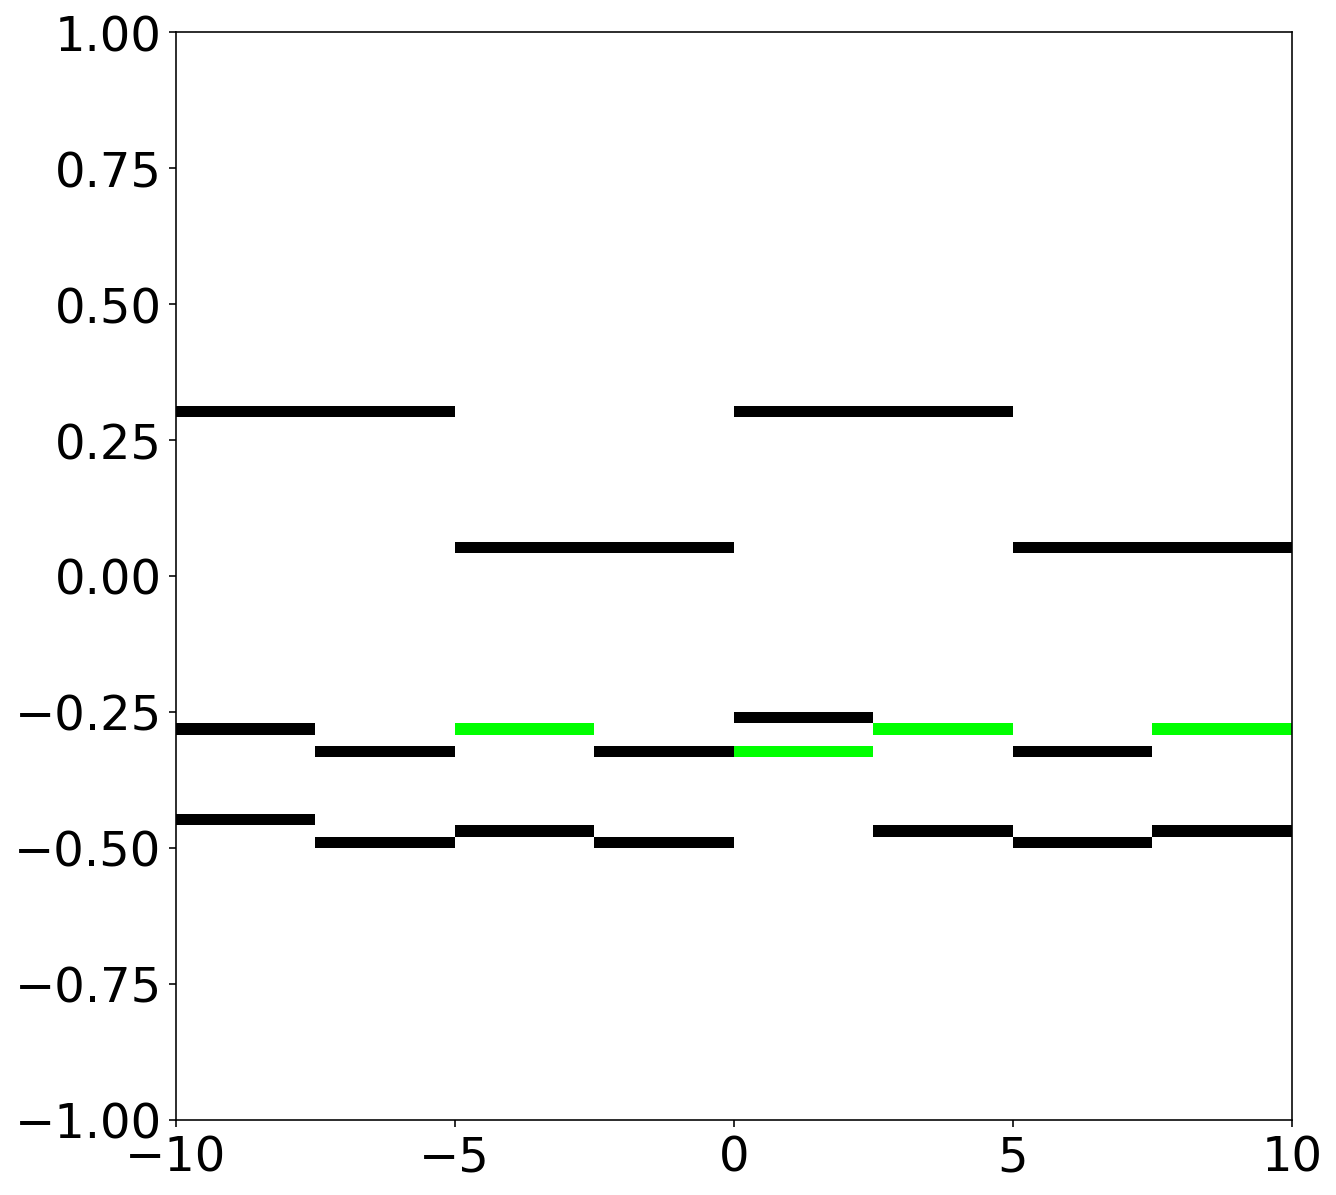

In [57]:
# Now let's pretend our channels are RGBA values and make a colored image

idx_all=np.arange(samples)
num_plot=10
for i in range(num_plot):
    
    idx=np.random.choice(idx_all,size=1)
    
    plt.imshow(ins[idx,:,:,:].reshape(image_height,image_width,num_channels),extent=[-10,10,-1,1],aspect='auto')
    #plt.axis('off')
    plt.show()

In [58]:
#fp=open("ins_convgan_final_fantasy_fifths.pkl",'wb')
#pickle.dump(ins,fp)
#fp.close()